**Assessing foraging landscape quality of commercial beekeeping in Quebec using remote sensing products, machine learning and survival analysis**
> Julien Vadnais, j.vadnais@umontreal.ca

> Liliana Perez, l.perez@umontreal.ca

> Nicolas Coallier, nico@nectar.buzz

> Maxime , Max's address

# packages & libraries


Required:
* geopandas
* lifelines
* matplotlib
* numpy
* pandas
* scikit-learn
* scikit-survival
* scipy
* seaborn
* shapely


Optional:
* bioinfokit 
* rtree

In [284]:
# Required
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import geopandas as gpd
import shapely
from geopandas.tools import sjoin
from shapely.geometry import Polygon, MultiPolygon

import scipy.spatial
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import r2_score

import lifelines
from lifelines import CoxTimeVaryingFitter

import sksurv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import cumulative_dynamic_auc

In [ ]:
# Optional
from adjustText import adjust_text
from bioinfokit.visuz import cluster
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import rtree
from sklearn.model_selection import GridSearchCV

# Datasets
Below are the dataset required to run this notebook 

**Beekeeping dataset** <br>
* QC colony reports 2021-2024

**Landscape metrics** <br>
*Based on a high-resolution remote-sensing crop map, metrics calculated in QGIS & ArcGIS Pro*
* 500-m buffer metrics
* 1000-m buffer metrics
* 2500-m buffer metrics
* 5000-m buffer metrics

**EVI data** <br>
*MODIS product extracted from GEE* 
* gdf_eo geojson file

**Elevation data** <br>
*DEM extracted from GEE* 
* gdf_eo geojson file

## Beekeeping dataset

In [3]:
# QC beekeeping reports 2021-2024
gdf = gpd.read_file(r'path',crs='EPSG:4326')
gdf.head()

,hive_age,report_submitted_at,hive_identity_id,category,action_detail,lon,lat,operation_id,is_alive,crop_type,geometry
0,0,2021-05-07 12:49:56+00:00,12449,,,-74.0656207820103,45.5640999708896,55,1,Pommes,POINT (-74.06562 45.5641)
1,41,2021-06-17 14:12:07+00:00,12449,,,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366)
2,41,2021-06-17 14:13:02+00:00,12449,hive grading,strong,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366)
3,66,2021-07-12 20:57:14+00:00,12449,queen management,reine at-10,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366)
4,81,2021-07-27 18:54:06+00:00,12449,queen management,c.a.,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366)


In [5]:
# date column to datetime format
gdf['date'] = pd.to_datetime(gdf['report_submitted_at'], utc=True)

# Creates a 'year' column 
gdf['year'] = gdf['date'].dt.year

gdf.head()

,hive_age,report_submitted_at,hive_identity_id,category,action_detail,lon,lat,operation_id,is_alive,crop_type,geometry,date,year
0,0,2021-05-07 12:49:56+00:00,12449,,,-74.0656207820103,45.5640999708896,55,1,Pommes,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021
1,41,2021-06-17 14:12:07+00:00,12449,,,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021
2,41,2021-06-17 14:13:02+00:00,12449,hive grading,strong,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021
3,66,2021-07-12 20:57:14+00:00,12449,queen management,reine at-10,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021
4,81,2021-07-27 18:54:06+00:00,12449,queen management,c.a.,-72.4513398999121,48.6236646998878,55,1,Canola,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021


In [6]:
gdf.isna().any()

hive_age               False
report_submitted_at    False
hive_identity_id       False
category               False
action_detail          False
lon                    False
lat                    False
operation_id           False
is_alive               False
crop_type              False
geometry               False
date                   False
year                   False
dtype: bool

In [7]:
# dropping columns which won't be used here
gdf.drop(columns={'report_submitted_at','category','crop_type','lat','lon','action_detail'},inplace=True,errors='ignore')

#renaming ID columns
gdf.rename(columns={'hive_identity_id':'hiveID','operation_id':'operationID'},inplace=True,errors='ignore')

In [8]:
gdf.dtypes

hive_age                    object
hiveID                      object
operationID                 object
is_alive                    object
geometry                  geometry
date           datetime64[ms, UTC]
year                         int32
dtype: object

In [9]:
# Converting to integer column type
gdf[['hiveID','operationID','is_alive','hive_age']] = gdf[['hiveID','operationID','is_alive','hive_age']].astype(int)

In [10]:
# explore the dataset
print('# Hive IDs:',gdf['hiveID'].nunique())
print('# operation IDs:',gdf['operationID'].nunique())

# Hive IDs: 18054
# operation IDs: 6


### Computing E and T

Survival analysis typically requires two features: E and T.
In our case,
* **E**, the event, indicates whether or not a colony has been reported dead in the data.
* **T**, the time until the event, is calculated the number of days until a hive has or has not been reported dead following its first report

#### Compute the event (E)

First, we compute the **E** event column 

In [11]:
# empty column to store the event values
gdf['E'] = None

# for loop to report last 'is_alive' value
for id in gdf['hiveID'].unique():
    # sorts values for each unique ID and gets the latest (last idx) 'is_alive' value
    temp = gdf.loc[gdf['hiveID'] == id].sort_values(by='date').iloc[-1]['is_alive']
    # If the last 'is_alive' value is 1, invert and set E to 0, if it is no, set E to 1
    gdf.loc[gdf['hiveID'] == id, 'E'] = abs(temp - 1)

In [12]:
gdf.loc[0]

hive_age                                                0
hiveID                                              12449
operationID                                            55
is_alive                                                1
geometry       POINT (-74.0656207820103 45.5640999708896)
date                            2021-05-07 12:49:56+00:00
year                                                 2021
E                                                       1
Name: 0, dtype: object

In [13]:
gdf = gdf.sort_values(by=['hiveID','date'])
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1


In [14]:
gdf.loc[gdf['hiveID']==12451].loc[gdf['is_alive']==0]

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E
36,321,12451,55,0,POINT (-74.08671 45.56662),2022-03-24 14:35:23.533000+00:00,2022,1
37,321,12451,55,0,POINT (-74.08671 45.56662),2022-05-12 11:30:00+00:00,2022,1


Check for 'false' or 'second' events

In [15]:
# # y2 is a dummy column to compare with E. This allows to check if a hiveID can be reported alive after being reported dead once.

# gdf['y2'] = None

# # Same as preceding loop but y2 = 0 if ANY 'is_alive' = 0
# for i in gdf['hiveID'].unique():
#     # sorts values for each unique ID and gets the latest (last idx) 'is_alive' value
#     temp = gdf.loc[gdf['hiveID'] == i]['is_alive'].min()
#     gdf.loc[gdf['hiveID'] == i, 'y2'] = abs(temp -1)

# gdf['y2'].value_counts()

In [16]:
gdf['E'].value_counts()

E
0    284654
1    185552
Name: count, dtype: int64

In [17]:
# It is perfect to see that no colonies has been reported alive after being reported dead. We can remove y2 column
gdf.drop(columns='y2',inplace=True,errors='ignore')

Removing reports after the event. <br>
Some beekeepers might report a hive after it's been reported dead already. We don't need these additional reports.

In [18]:
# creates a list comprising the first event report for each hiveID
event_indices = gdf[gdf['is_alive'] == 0].groupby('hiveID')['date'].idxmin()
event_indices

hiveID
12449          7
12450         13
12451         36
12452         61
12454        124
           ...  
201412    328469
201413    328474
201424    328490
201964    328550
278368    330759
Name: date, Length: 8348, dtype: int64

In [19]:
# Creates a boolean masking array. For each index, the values of hiveID and the index is compared to have a true/false value.
bool_array = gdf.index <= gdf['hiveID'].map(event_indices)
bool_array

array([ True,  True,  True, ..., False, False, False])

In [20]:
# Applies the masking array to keep only those with a 'True' value 
gdf = gdf[bool_array | gdf['hiveID'].map(event_indices).isna()].copy()

In [21]:
# resets the index and drops the old one
gdf = gdf.reset_index(drop=True)

gdf.head(n=40)

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1
5,89,12449,55,1,POINT (-72.45134 48.62366),2021-08-04 19:14:33+00:00,2021,1
6,96,12449,55,1,POINT (-72.45134 48.62366),2021-08-11 18:45:17+00:00,2021,1
7,102,12449,55,0,POINT (-72.58278 48.66917),2021-08-17 14:54:26+00:00,2021,1
8,0,12450,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1
9,41,12450,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1


#### Compute the time (T)

We can compute the **T** value by calculating the difference between the first and the last report, for each hiveID. <br>
It must not be confused with the 'hive_age' feature in the dataset, which was previously computed, and which represents the punctual hive_age at a report.

In [22]:
# create empty column
gdf['T'] = None

# for loop to calculate total days reported alive
for id in gdf['hiveID'].unique():
    diff = gdf.loc[gdf['hiveID'] == id, 'date'].max() - gdf.loc[gdf['hiveID'] == id, 'date'].min()
    gdf.loc[gdf['hiveID'] == id, 'T'] = diff

In [23]:
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102 days 02:04:30
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102 days 02:04:30
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102 days 02:04:30
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102 days 02:04:30
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102 days 02:04:30


In [24]:
# converting to integer format the number of days alive
gdf['T'] = gdf['T'].apply(lambda x: x.days)

In [25]:
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102


Removing 'one-report' hives

In [26]:
# 763 hives have been reported only once. Therefore they don't have value for survival analysis.
gdf[gdf['T']==0]['hiveID'].nunique()

763

In [27]:
gdf[gdf['T'] > 0]['hiveID'].nunique()

17291

In [28]:
# From 18054 to 17291. We can remove those only reported once.
gdf = gdf[gdf['T'] > 0]

## Landscape metrics

### Landscape Shannon diversity Index (SDI) and richness

#### 500-m buffer

In [29]:
# reading the file
metrics500 = gpd.read_file(r'path.geojson')
metrics500.columns

Index(['OBJECTID', 'hive_age', 'report_sub', 'hive_ident', 'category',
       'action_det', 'lon', 'lat', 'operation_', 'is_alive', 'crop_type',
       'tag_serial', 'report_s_1', 'report_rep', 'yard_name', 'report_not',
       'queen_vari', 'queen_stat', 'state_prov', 'country_lo', 'city',
       'yard_type', 'layer', 'path', 'Div_sh', 'Shape_Length', 'Shape_Area',
       'MAJORITY', 'VARIETY', 'geometry'],
      dtype='object')

In [30]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics500['lon'], metrics500['lat'])]

# temp gdf to merde landscape metrics at 1000m
gdf_temp = gpd.GeoDataFrame(metrics500, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column 
gdf_temp.rename(columns={'Div_sh':'sdi_500','MAJORITY':'maj_500','VARIETY':'rich_500'},inplace=True,errors='ignore')

In [31]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_500','maj_500','rich_500']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T,sdi_500,maj_500,rich_500
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102,0.843937,220,6
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102,1.128067,122,9
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102,1.128067,122,9
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102,1.128067,122,9
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102,1.128067,122,9


In [32]:
#Nan check
gdf.isna().sum()

hive_age       0
hiveID         0
operationID    0
is_alive       0
geometry       0
date           0
year           0
E              0
T              0
sdi_500        0
maj_500        0
rich_500       0
dtype: int64

#### 1000-m buffer

In [33]:
metrics1000 = gpd.read_file(r'path.geojson')
metrics1000.columns

Index(['hive_ident', 'lon', 'lat', 'Div_sh', 'tag_serial', 'hive_age', 'fob',
       'fobr', 'grade', 'varroa', 'report_sub', 'category', 'action_det',
       'report_rep', 'yard_name', 'report_not', 'operation_', 'is_alive',
       'queen_vari', 'queen_stat', 'state_prov', 'country_lo', 'city',
       'yard_type', 'crop_type', '_majority', '_variety', 'layer', 'path',
       'geometry'],
      dtype='object')

In [34]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics1000['lon'], metrics1000['lat'])]

# temp gdf to merde landscape metrics at 1000m
gdf_temp = gpd.GeoDataFrame(metrics1000, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column and the majority (dominant crop type in buffer)
gdf_temp.rename(columns={'Div_sh':'sdi_1000','_majority':'maj_1000','_variety':'rich_1000'},inplace=True,errors='ignore')


In [35]:
gdf_temp['geometry'].nunique()

1384

In [36]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_1000','maj_1000','rich_1000']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T,sdi_500,maj_500,rich_500,sdi_1000,maj_1000,rich_1000
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102,0.843937,220,6,1.070746,220.0,12.0
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0


In [37]:
#Nan check
gdf.isna().sum()

hive_age       0
hiveID         0
operationID    0
is_alive       0
geometry       0
date           0
year           0
E              0
T              0
sdi_500        0
maj_500        0
rich_500       0
sdi_1000       0
maj_1000       0
rich_1000      0
dtype: int64

#### 2500-m buffer

In [38]:
metrics2500 = gpd.read_file(r'path.geojson')
metrics2500.columns

Index(['hive_ident', 'lon', 'lat', '_majority', '_variety', 'tag_serial',
       'hive_age', 'fob', 'fobr', 'grade', 'varroa', 'report_sub', 'category',
       'action_det', 'report_rep', 'yard_name', 'report_not', 'operation_',
       'is_alive', 'queen_vari', 'queen_stat', 'state_prov', 'country_lo',
       'city', 'yard_type', 'crop_type', 'Div_sh', 'geometry'],
      dtype='object')

In [39]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics2500['lon'], metrics2500['lat'])]

# temp gdf to merde landscape metrics at 2500m
gdf_temp = gpd.GeoDataFrame(metrics2500, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column and the majority (dominant crop type in buffer)
gdf_temp.rename(columns={'Div_sh':'sdi_2500','_majority':'maj_2500','_variety':'rich_2500'},inplace=True,errors='ignore')


In [40]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_2500','maj_2500','rich_2500']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T,sdi_500,maj_500,rich_500,sdi_1000,maj_1000,rich_1000,sdi_2500,maj_2500,rich_2500
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102,0.843937,220,6,1.070746,220.0,12.0,1.773718,220,15
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0,2.196193,122,21
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0,2.196193,122,21
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0,2.196193,122,21
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102,1.128067,122,9,1.479712,122.0,13.0,2.196193,122,21


In [41]:
#Nan check
gdf.isna().sum()

hive_age       0
hiveID         0
operationID    0
is_alive       0
geometry       0
date           0
year           0
E              0
T              0
sdi_500        0
maj_500        0
rich_500       0
sdi_1000       0
maj_1000       0
rich_1000      0
sdi_2500       0
maj_2500       0
rich_2500      0
dtype: int64

#### 5000-m buffer

In [42]:
metrics5000 = gpd.read_file(r'path.geojson')
metrics5000.columns

Index(['hive_ident', 'lon', 'lat', 'Div_sh', 'tag_serial', 'hive_age', 'fob',
       'fobr', 'grade', 'varroa', 'report_sub', 'category', 'action_det',
       'report_rep', 'yard_name', 'report_not', 'operation_', 'is_alive',
       'queen_vari', 'queen_stat', 'state_prov', 'country_lo', 'city',
       'yard_type', 'crop_type', '_majority', '_variety', 'geometry'],
      dtype='object')

In [43]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics5000['lon'], metrics5000['lat'])]

# temp gdf to merde landscape metrics at 1000m
gdf_temp = gpd.GeoDataFrame(metrics5000, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column and the majority (dominant crop type in buffer)
gdf_temp.rename(columns={'Div_sh':'sdi_5000','_majority':'maj_5000','_variety':'rich_5000'},inplace=True,errors='ignore')


In [44]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_5000','maj_5000','rich_5000']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T,sdi_500,...,rich_500,sdi_1000,maj_1000,rich_1000,sdi_2500,maj_2500,rich_2500,sdi_5000,maj_5000,rich_5000
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102,0.843937,...,6,1.070746,220.0,12.0,1.773718,220,15,1.892978,158.0,19.0
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102,1.128067,...,9,1.479712,122.0,13.0,2.196193,122,21,2.540201,122.0,26.0
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102,1.128067,...,9,1.479712,122.0,13.0,2.196193,122,21,2.540201,122.0,26.0
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102,1.128067,...,9,1.479712,122.0,13.0,2.196193,122,21,2.540201,122.0,26.0
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102,1.128067,...,9,1.479712,122.0,13.0,2.196193,122,21,2.540201,122.0,26.0


In [45]:
#Nan check
gdf.isna().sum()

hive_age       0
hiveID         0
operationID    0
is_alive       0
geometry       0
date           0
year           0
E              0
T              0
sdi_500        0
maj_500        0
rich_500       0
sdi_1000       0
maj_1000       0
rich_1000      0
sdi_2500       0
maj_2500       0
rich_2500      0
sdi_5000       0
maj_5000       0
rich_5000      0
dtype: int64

## Enhanced vegetation index (EVI) data

We pre-calculated a series of EVI data. This was retrieved using google earth engine from a MODIS products. If you would like to run the retrieving process, please see ***Appendix 1***. Consider 1-2 hours for the whole process.

In [46]:
gdf_eo = gpd.read_file(r'path',crs='EPSG:4326')
gdf_eo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
# We shall only use the Enhanced Vegetation Index.
gdf_eo.drop(columns={'fpar_apr','fpar_jul','fpar_oct','lai_apr','lai_jul','lai_oct'},inplace=True,errors='ignore')
gdf_eo['geometry'].nunique()

1334

### Spatial join

we import a spatial index tool to speed up spatial joins

In [48]:
# reimport fix
import geopandas
import rtree

# creates a spatial index using geopandas.sindex and rtree
sindex = gdf_eo.sindex

# spatial index check
gdf_eo.has_sindex

True

With the spatial index created, this shouldn't take more than a few seconds

In [49]:
# Perform the spatial join (uses the spatial index)
gdf = sjoin(gdf, gdf_eo, how='left')

# Na values check
gdf.isna().any()

hive_age       False
hiveID         False
operationID    False
is_alive       False
geometry       False
date           False
year           False
E              False
T              False
sdi_500        False
maj_500        False
rich_500       False
sdi_1000       False
maj_1000       False
rich_1000      False
sdi_2500       False
maj_2500       False
rich_2500      False
sdi_5000       False
maj_5000       False
rich_5000      False
index_right    False
evi_apr        False
evi_jul        False
evi_oct        False
dtype: bool

In [50]:
gdf.drop(columns='index_right',inplace=True,errors='ignore')

In [51]:
gdf.head()

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T,sdi_500,...,rich_1000,sdi_2500,maj_2500,rich_2500,sdi_5000,maj_5000,rich_5000,evi_apr,evi_jul,evi_oct
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102,0.843937,...,12.0,1.773718,220,15,1.892978,158.0,19.0,0.1822,0.8024,0.2936
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102,1.128067,...,13.0,2.196193,122,21,2.540201,122.0,26.0,0.1974,0.6298,0.4678
2,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:13:02+00:00,2021,1,102,1.128067,...,13.0,2.196193,122,21,2.540201,122.0,26.0,0.1974,0.6298,0.4678
3,66,12449,55,1,POINT (-72.45134 48.62366),2021-07-12 20:57:14+00:00,2021,1,102,1.128067,...,13.0,2.196193,122,21,2.540201,122.0,26.0,0.1974,0.6298,0.4678
4,81,12449,55,1,POINT (-72.45134 48.62366),2021-07-27 18:54:06+00:00,2021,1,102,1.128067,...,13.0,2.196193,122,21,2.540201,122.0,26.0,0.1974,0.6298,0.4678


## Topographic data

Additional topographic data can add another quantitative characteristic to describe the foraging landscape

The Canadian Digital Elevation Model (CDEM) Product covers our study, and its use has been well proven. Source: Canada Centre for Mapping and Earth observation, Natural Resources Canada (2013). url: https://ftp.geogratis.gc.ca/pub/nrcan_rncan/elevation/cdem_mnec/doc/CDEM_product_specs.pdf

In [2]:
# earth engine 
ee.Authenticate()

NameError: name 'ee' is not defined

In [54]:
ee.Initialize(project='"project_path"')

In [ ]:
# Creates a unique geometry gdf to avoid redundancy
ugdf = gdf.drop_duplicates(subset='geometry')

In [55]:
# function for elevation
def get_elevation(point):
  poi = ee.Geometry.Point(point.x, point.y)
  
  collection = ee.ImageCollection('NRCan/CDEM').filterBounds(poi)
  scale = 30  # ee says 23 m resolution but to vary between 20 and 30+ m depending on latitudes

  # Extract elevation at point location
  elev = collection.first().sample(poi, scale).first().get('elevation').getInfo()

  #print(elev)

  return elev

Alongside raw elevation, we can compute the std dev of elevation in a buffer to assess whether the location is a rather hilly or flat landscape

In [58]:
# function for std of elevation
def get_std_dev_elevation(point):
        # Need to convert to Earth Engine geometry
        poi = ee.Geometry.Point([point.x, point.y])
        
        # Define a 300m buffer around the point
        buffer = poi.buffer(300)  # Buffer in meters
        
        # select the NRCAN DEM image collection
        collection = ee.ImageCollection('NRCan/CDEM').filterBounds(buffer)
        image = ee.Image(collection.first())
        
        # Compute statistics within the buffer region
        stats = image.reduceRegion(
            reducer=ee.Reducer.stdDev(),
            geometry=buffer,
            scale=30,  # ee says 23 m resolution but to vary between 20 and 30+ m depending on latitudes
        )
        
        # Extract the standard deviation value
        std_dev = stats.get('elevation').getInfo()
        
        return std_dev

# Apply to function to unique geometry gdf
ugdf['elevation_std_dev'] = ugdf['geometry'].apply(lambda point: get_std_dev_elevation(point))

c:\Users\juvad3723\AppData\Local\miniforge3\envs\a2-env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


6 mins

In [59]:
# Get elevations for each point in the GeoDataFrame
ugdf['elevation'] = ugdf['geometry'].apply(lambda point: get_elevation(point))

108
110
177
83
49
164
120
21
22
45
60
57
181
117
139
80
111
170
70
182
110
164
42
70
83
160
145
106
60
76
76
98
81
105
164
168
113
118
73
150
54
50
59
168
82
163
79
61
163
160
299
167
93
170
200
92
92
95
156
119
77
165
79
174
103
53
69
87
161
166
167
136
163
169
65
40
109
80
98
215
84
152
143
120
111
122
50
51
75
161
49
170
184
83
80
161
173
183
98
74
52
180
120
109
168
82
158
111
135
54
41
171
70
171
133
134
125
72
171
79
80
115
116
106
165
81
169
135
156
244
168
81
82
214
214
51
100
190
183
61
127
166
166
183
80
169
50
134
169
110
91
138
41
50
107
166
173
45
45
161
168
162
118
119
174
49
160
130
67
168
63
62
166
169
84
83
97
164
114
130
166
126
151
156
163
55
50
50
69
120
111
74
166
62
113
166
112
33
169
165
172
162
66
171
169
140
163
185
59
110
158
162
170
75
119
107
67
69
167
55
116
105
320
102
80
171
163
112
154
164
54
38
73
103
51
170
89
82
41
60
59
91
166
135
166
53
215
117
155
153
162
141
164
60
47
153
161
76
106
83
175
81
110
83
168
100
49
120
54
70
54
41
54
168
89
161
74
103


c:\Users\juvad3723\AppData\Local\miniforge3\envs\a2-env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [60]:
ugdf.head(n=30)

,hive_age,hiveID,operationID,is_alive,geometry,date,year,E,T,sdi_500,...,maj_2500,rich_2500,sdi_5000,maj_5000,rich_5000,evi_apr,evi_jul,evi_oct,elevation_std_dev,elevation
0,0,12449,55,1,POINT (-74.06562 45.5641),2021-05-07 12:49:56+00:00,2021,1,102,0.843937,...,220,15,1.892978,158.0,19.0,0.1822,0.8024,0.2936,17.551818,108
1,41,12449,55,1,POINT (-72.45134 48.62366),2021-06-17 14:12:07+00:00,2021,1,102,1.128067,...,122,21,2.540201,122.0,26.0,0.1974,0.6298,0.4678,1.396418,110
7,102,12449,55,0,POINT (-72.58278 48.66917),2021-08-17 14:54:26+00:00,2021,1,102,1.747352,...,230,19,2.092969,230.0,20.0,0.1365,0.6899,0.1930,3.022843,177
20,131,12451,55,1,POINT (-74.06024 45.65589),2021-09-15 20:51:24+00:00,2021,1,321,1.094818,...,122,13,1.885838,220.0,18.0,-0.0329,0.7236,0.3032,1.271944,83
32,298,12451,55,1,POINT (-74.08671 45.56662),2022-03-01 21:25:33.040000+00:00,2022,1,321,0.896203,...,158,16,1.813423,158.0,20.0,0.1238,0.5611,0.1573,2.329050,49
56,312,12452,55,1,POINT (-74.06328 45.52376),2022-03-15 20:06:35.946000+00:00,2022,1,351,1.634998,...,158,18,1.825330,220.0,21.0,0.1657,0.4644,0.3591,15.455486,164
59,26,12454,55,1,POINT (-72.28254 48.78149),2021-06-02 10:38:18+00:00,2021,1,1071,0.031377,...,182,12,2.000343,80.0,16.0,0.0148,0.4682,0.2249,0.563384,120
60,48,12454,55,1,POINT (-73.62592 45.642),2021-06-24 12:55:06+00:00,2021,1,1071,1.236340,...,34,11,1.486826,34.0,16.0,0.0160,0.4166,0.1281,1.546747,21
61,90,12454,55,1,POINT (-73.63023 45.64955),2021-08-05 18:20:10+00:00,2021,1,1071,1.651665,...,34,11,1.617538,34.0,16.0,0.1413,0.5381,0.2207,1.893056,22
65,298,12454,55,1,POINT (-74.08305 45.56786),2022-03-01 15:47:24.121000+00:00,2022,1,1071,0.726420,...,158,16,1.819894,158.0,20.0,0.1299,0.5997,0.1903,2.979601,45


In [61]:
sindex = ugdf.sindex

In [62]:
ugdf.has_sindex

True

In [63]:
# Perform the spatial join (uses the spatial index)
gdf = sjoin(gdf, ugdf[['geometry','elevation','elevation_std_dev']], how='left',)

# Na values check
gdf.isna().any()

hive_age             False
hiveID               False
operationID          False
is_alive             False
geometry             False
date                 False
year                 False
E                    False
T                    False
sdi_500              False
maj_500              False
rich_500             False
sdi_1000             False
maj_1000             False
rich_1000            False
sdi_2500             False
maj_2500             False
rich_2500            False
sdi_5000             False
maj_5000             False
rich_5000            False
evi_apr              False
evi_jul              False
evi_oct              False
index_right          False
elevation            False
elevation_std_dev    False
dtype: bool

In [64]:
gdf['elevation'] = gdf['elevation'].astype(int)

In [65]:
print(f'mean elevation of reports : {gdf['elevation'].mean()}')
print(f'median elevation of reports : {gdf['elevation'].median()}')
print(f'min elevation of reports : {gdf['elevation'].min()}')
print(f'max elevation of reports : {gdf['elevation'].max()}')

mean elevation of reports : 115.53369278634338
median elevation of reports : 90.0
min elevation of reports : 5
max elevation of reports : 380


In [66]:
backup_1 = gdf.copy()

In [67]:
# backup_1.to_file(r'path.geojson',driver='GeoJSON')

# Backup 1
Run below to use backup

In [535]:
gdf = backup_1.copy()

In [536]:
gdf.isna().any()

hive_age             False
hiveID               False
operationID          False
is_alive             False
geometry             False
date                 False
year                 False
E                    False
T                    False
sdi_500              False
maj_500              False
rich_500             False
sdi_1000             False
maj_1000             False
rich_1000            False
sdi_2500             False
maj_2500             False
rich_2500            False
sdi_5000             False
maj_5000             False
rich_5000            False
evi_apr              False
evi_jul              False
evi_oct              False
index_right          False
elevation            False
elevation_std_dev    False
dtype: bool

# Feature engineering

In [537]:
# reorder columns
gdf = gdf[['hiveID','year','date','operationID','is_alive','E','T','hive_age',
           'maj_500','maj_1000','maj_2500','maj_5000',
           'rich_500','rich_1000','rich_2500','rich_5000',
           'sdi_500','sdi_1000','sdi_2500','sdi_5000',
           'evi_apr','evi_jul','evi_oct',
           'elevation','elevation_std_dev',
           'geometry']]

In [538]:
gdf.head()

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_500,sdi_1000,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry
0,12449,2021,2021-05-07 12:49:56+00:00,55,1,1,102,0,220,220.0,...,0.843937,1.070746,1.773718,1.892978,0.1822,0.8024,0.2936,108,17.551818,POINT (-74.06562 45.5641)
1,12449,2021,2021-06-17 14:12:07+00:00,55,1,1,102,41,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)
2,12449,2021,2021-06-17 14:13:02+00:00,55,1,1,102,41,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)
3,12449,2021,2021-07-12 20:57:14+00:00,55,1,1,102,66,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)
4,12449,2021,2021-07-27 18:54:06+00:00,55,1,1,102,81,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)


## Time-weighted average (TWA)

Beehives used in commercial beekeeping often get moved during the beekeeping season to fulfill pollination contracts. <br>
Here, we account for this movement by calculating a Time-Weighted Average (TWA) of the landscape metrics of each location that a colony met during its lifetime. 

The proceding steps are as follows:
* Make sure the df is ordered properly
* Calculate the time interval between each reports for a same hive
* Calculate the TWA value for each metrics

### Ordering the df

First, we want to order correctly the reports.

We can order solely by hiveID and 'date' since the 'date' feature includes the hour of report!

In [541]:
#Sorts the gdf by hiveID and time of report
gdf = gdf.sort_values(['hiveID','date'])
gdf = gdf.reset_index(drop=True)
gdf.head()

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_500,sdi_1000,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry
0,12449,2021,2021-05-07 12:49:56+00:00,55,1,1,102,0,220,220.0,...,0.843937,1.070746,1.773718,1.892978,0.1822,0.8024,0.2936,108,17.551818,POINT (-74.06562 45.5641)
1,12449,2021,2021-06-17 14:12:07+00:00,55,1,1,102,41,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)
2,12449,2021,2021-06-17 14:13:02+00:00,55,1,1,102,41,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)
3,12449,2021,2021-07-12 20:57:14+00:00,55,1,1,102,66,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)
4,12449,2021,2021-07-27 18:54:06+00:00,55,1,1,102,81,122,122.0,...,1.128067,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366)


In [542]:
# Let's drop duplicate reports
gdf = gdf.drop_duplicates(['hiveID','date','geometry','is_alive'])

### Calculate report time intervals

In [543]:
# We calculate the time_interval as absolute between reports  of the same hiveID. We fill the NaN (last reports of each group) with a value of 0 days
gdf.loc[:,'time_interval'] = gdf.groupby('hiveID')['date'].transform(lambda x: abs(x.diff(periods=-1)).fillna(pd.Timedelta(0)))
gdf.head()

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_1000,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry,time_interval
0,12449,2021,2021-05-07 12:49:56+00:00,55,1,1,102,0,220,220.0,...,1.070746,1.773718,1.892978,0.1822,0.8024,0.2936,108,17.551818,POINT (-74.06562 45.5641),41 days 01:22:11
1,12449,2021,2021-06-17 14:12:07+00:00,55,1,1,102,41,122,122.0,...,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366),0 days 00:00:55
2,12449,2021,2021-06-17 14:13:02+00:00,55,1,1,102,41,122,122.0,...,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366),25 days 06:44:12
3,12449,2021,2021-07-12 20:57:14+00:00,55,1,1,102,66,122,122.0,...,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366),14 days 21:56:52
4,12449,2021,2021-07-27 18:54:06+00:00,55,1,1,102,81,122,122.0,...,1.479712,2.196193,2.540201,0.1974,0.6298,0.4678,110,1.396418,POINT (-72.45134 48.62366),8 days 00:20:27


In [544]:
gdf['time_interval'].min()

Timedelta('0 days 00:00:00')

This looks good. However, what happens in the winter? <br>

In [545]:
# Check for a hive that is wintered over a season
gdf[gdf['hiveID']==12531]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_1000,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry,time_interval
2796,12531,2021,2021-05-07 13:55:46+00:00,55,1,1,327,0,220,220.0,...,1.535614,1.792576,1.942585,0.2123,0.7880,0.2104,106,8.743204,POINT (-74.04913 45.5578),16 days 23:07:33
2797,12531,2021,2021-05-24 13:03:19+00:00,55,1,1,327,17,182,182.0,...,1.244288,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),0 days 00:00:22
2798,12531,2021,2021-05-24 13:03:41+00:00,55,1,1,327,17,182,182.0,...,1.244288,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),84 days 23:52:16
2799,12531,2021,2021-08-17 12:55:57+00:00,55,1,1,327,102,122,122.0,...,1.540623,1.876049,1.399196,0.1891,0.5770,0.4284,174,3.391142,POINT (-76.66176 45.89793),195 days 03:59:12.282000
2800,12531,2022,2022-02-28 16:55:09.282000+00:00,55,1,1,327,297,158,158.0,...,1.541221,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),30 days 01:53:07.566000
2801,12531,2022,2022-03-30 18:48:16.848000+00:00,55,0,1,327,327,158,158.0,...,1.541221,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),0 days 00:00:00


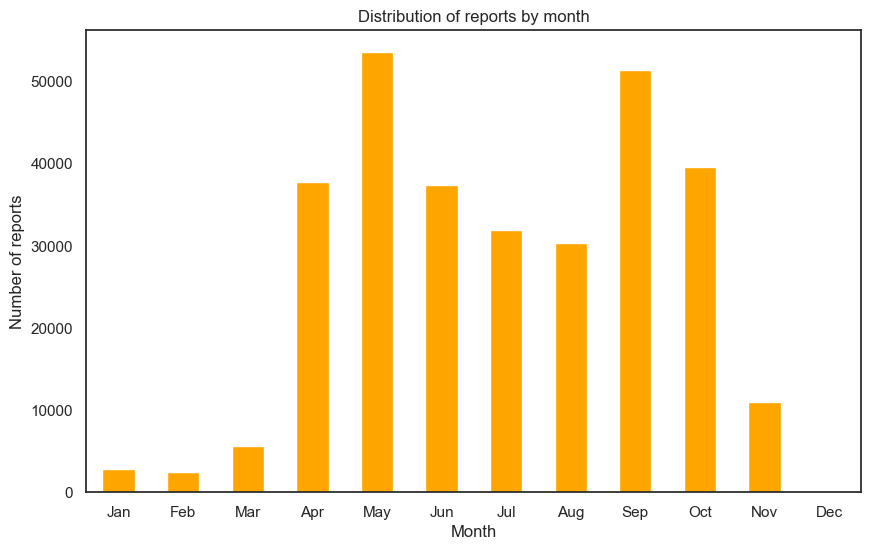

In [546]:
# creates a month column
gdf['month'] = gdf['date'].dt.month

# creates a monthly distribution count 
monthly_distribution = gdf['month'].value_counts().sort_index()

# Plot the distribution count per months
plt.figure(figsize=(10, 6))
monthly_distribution.plot(kind='bar', color='orange')
plt.title('Distribution of reports by month')
plt.xlabel('Month')
plt.ylabel('Number of reports')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

In Quebec, hives are wintered and stop foraging. Therefore, we must not account for the landscape metrics during the winter months. <br>
Looking at the last report of the season on August 17, we see that the time_interval is overestimated with 195 days. Let's fix that

Since we are assessing foraging landscape quality, let's define limit days to account only for the beekeeping season. <br> We'll use November 15 as the latest date and March 1st as the earliest date.

In [547]:
# Check reports made after the end of the beekeeping season
gdf.loc[(gdf['date'].dt.month == 11) & (gdf['date'].dt.day > 15) | (gdf['date'].dt.month == 12),'date']

213952   2022-11-16 18:19:38.002000+00:00
214053   2022-12-20 14:27:30.901000+00:00
222014   2022-11-16 17:14:28.556000+00:00
222112   2022-11-16 18:19:38.002000+00:00
222334   2022-11-16 18:08:24.937000+00:00
                       ...               
460741          2023-11-22 04:26:22+00:00
460795          2023-11-22 04:26:22+00:00
460893          2023-11-22 04:26:22+00:00
460895          2023-11-22 04:26:22+00:00
461453          2023-11-22 04:26:22+00:00
Name: date, Length: 4933, dtype: datetime64[ms, UTC]

In [548]:
# Check reports made before the start of the beekeeping season
gdf.loc[(gdf['date'].dt.month == 2) | (gdf['date'].dt.month == 1),'date']

161      2022-02-28 19:57:19.047000+00:00
165      2022-02-28 19:57:19.047000+00:00
569      2022-02-28 19:57:19.047000+00:00
958      2022-02-28 19:57:19.047000+00:00
1255     2022-02-28 19:57:19.047000+00:00
                       ...               
451091   2024-02-27 18:20:07.506000+00:00
457253   2024-02-20 18:53:52.565000+00:00
457743   2024-02-10 19:01:37.966000+00:00
457744   2024-02-27 17:31:02.187000+00:00
457763   2024-02-20 22:07:28.326000+00:00
Name: date, Length: 5288, dtype: datetime64[ms, UTC]

In [549]:
# Creates a boolean mask to select the reports made after November 15 of the year
bool_mask = ((gdf['date'].dt.month == 11) & (gdf['date'].dt.day > 15)) | (gdf['date'].dt.month == 12)

# Applies a lambda function on the masked reports to change the date to Nov 15 of the same year
gdf.loc[bool_mask, 'date'] = gdf.loc[bool_mask, 'date'].apply(lambda x: pd.Timestamp(f'{x.year}-11-15 23:59:00', tz='UTC'))


In [550]:
# Check the difference
gdf.loc[(gdf['date'].dt.month == 11) & (gdf['date'].dt.day >= 15) | (gdf['date'].dt.month == 12),'date']

213952   2022-11-15 23:59:00+00:00
214053   2022-11-15 23:59:00+00:00
222014   2022-11-15 23:59:00+00:00
222112   2022-11-15 23:59:00+00:00
222334   2022-11-15 23:59:00+00:00
                    ...           
460741   2023-11-15 23:59:00+00:00
460795   2023-11-15 23:59:00+00:00
460893   2023-11-15 23:59:00+00:00
460895   2023-11-15 23:59:00+00:00
461453   2023-11-15 23:59:00+00:00
Name: date, Length: 4935, dtype: datetime64[ms, UTC]

We can repeat this for reports made early in the year, in winter months. Let's deplace them to March 1st

In [551]:
# Creates a boolean mask to select the reports made before March of the year
bool_mask = (gdf['date'].dt.month == 2) | (gdf['date'].dt.month == 1)

# Applies a lambda function on the masked reports to change the date to March 1st of the same year
gdf.loc[bool_mask, 'date'] = gdf.loc[bool_mask, 'date'].apply(lambda x: pd.Timestamp(f'{x.year}-03-01 00:00:01', tz='UTC'))


In [552]:
# Check the difference
gdf.loc[(gdf['date'].dt.month == 2) | (gdf['date'].dt.month == 1),'date']

Series([], Name: date, dtype: datetime64[ms, UTC])

In [553]:
# Check new monthly distribution
gdf['month'] = gdf['date'].dt.month
monthly_distribution

month
1      2787
2      2501
3      5592
4     37808
5     53570
6     37461
7     31967
8     30342
9     51454
10    39551
11    10979
12       93
Name: count, dtype: int64

Now, let's recalculate the time_intervals.

In [554]:
# We calculate the time_interval as absolute between reports  of the same hiveID. We fill the NaN (last reports of each group) with a value of 0 days
gdf.loc[:,'time_interval'] = gdf.groupby('hiveID')['date'].transform(lambda x: abs(x.diff(periods=-1)).fillna(pd.Timedelta(0)))

# Check for a hive that is wintered over a season
gdf[gdf['hiveID']==12531]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry,time_interval,month
2796,12531,2021,2021-05-07 13:55:46+00:00,55,1,1,327,0,220,220.0,...,1.792576,1.942585,0.2123,0.7880,0.2104,106,8.743204,POINT (-74.04913 45.5578),16 days 23:07:33,5
2797,12531,2021,2021-05-24 13:03:19+00:00,55,1,1,327,17,182,182.0,...,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),0 days 00:00:22,5
2798,12531,2021,2021-05-24 13:03:41+00:00,55,1,1,327,17,182,182.0,...,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),84 days 23:52:16,5
2799,12531,2021,2021-08-17 12:55:57+00:00,55,1,1,327,102,122,122.0,...,1.876049,1.399196,0.1891,0.5770,0.4284,174,3.391142,POINT (-76.66176 45.89793),195 days 11:04:04,8
2800,12531,2022,2022-03-01 00:00:01+00:00,55,1,1,327,297,158,158.0,...,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),29 days 18:48:15.848000,3
2801,12531,2022,2022-03-30 18:48:16.848000+00:00,55,0,1,327,327,158,158.0,...,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),0 days 00:00:00,3


We now should fix the time_interval for cases such as hive 12531 (195 days)

In [555]:
# We define a function to calculate the time difference with November 16st
def calc_diff_with_nov(group):
    # Extracts the year from the group index
    year = group.name[1]  # The 'year' is the second element in the tuple if the index is ('hiveID', 'year')
    
    # Calculates November 16 of the given year for all rows.
    latest_date = pd.Timestamp(f'{year}-11-16', tz='UTC')
    
    # Calculate the difference in days for the last report of each group
    group.loc[group.index[-1], 'time_interval'] = (latest_date - group['date'].iloc[-1])
    
    return group

# applies the function to each group and drops the grouping index
gdf = gdf.groupby(['hiveID', 'year']).apply(calc_diff_with_nov)
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\3955762744.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby(['hiveID', 'year']).apply(calc_diff_with_nov)


In [556]:
# New check, after fix, for a hive that is wintered over a season
gdf[gdf['hiveID']==12531]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry,time_interval,month
1807,12531,2021,2021-05-07 13:55:46+00:00,55,1,1,327,0,220,220.0,...,1.792576,1.942585,0.2123,0.7880,0.2104,106,8.743204,POINT (-74.04913 45.5578),16 days 23:07:33,5
1808,12531,2021,2021-05-24 13:03:19+00:00,55,1,1,327,17,182,182.0,...,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),0 days 00:00:22,5
1809,12531,2021,2021-05-24 13:03:41+00:00,55,1,1,327,17,182,182.0,...,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),84 days 23:52:16,5
1810,12531,2021,2021-08-17 12:55:57+00:00,55,1,1,327,102,122,122.0,...,1.876049,1.399196,0.1891,0.5770,0.4284,174,3.391142,POINT (-76.66176 45.89793),90 days 11:04:03,8
1811,12531,2022,2022-03-01 00:00:01+00:00,55,1,1,327,297,158,158.0,...,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),29 days 18:48:15.848000,3
1812,12531,2022,2022-03-30 18:48:16.848000+00:00,55,0,1,327,327,158,158.0,...,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),230 days 05:11:43.152000,3


In [557]:
gdf['time_interval'].min()

Timedelta('0 days 00:00:00')

While the interval of the fall last report is fixed, we can see the last report is messed up. The last report, whether it indicates a colony death or not, should have a time_interval of 0.

In [558]:
# For each hiveID, set the time_interval of the last report to 0.
gdf['time_interval'] = gdf.groupby('hiveID')['time_interval'].transform(lambda x: x.where(x.index != x.index[-1], pd.Timedelta(0)))

# Recheck
gdf[gdf['hiveID']==12531]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,sdi_2500,sdi_5000,evi_apr,evi_jul,evi_oct,elevation,elevation_std_dev,geometry,time_interval,month
1807,12531,2021,2021-05-07 13:55:46+00:00,55,1,1,327,0,220,220.0,...,1.792576,1.942585,0.2123,0.7880,0.2104,106,8.743204,POINT (-74.04913 45.5578),16 days 23:07:33,5
1808,12531,2021,2021-05-24 13:03:19+00:00,55,1,1,327,17,182,182.0,...,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),0 days 00:00:22,5
1809,12531,2021,2021-05-24 13:03:41+00:00,55,1,1,327,17,182,182.0,...,1.473348,1.820162,0.2253,0.5553,0.2712,167,2.927431,POINT (-71.84579 48.83817),84 days 23:52:16,5
1810,12531,2021,2021-08-17 12:55:57+00:00,55,1,1,327,102,122,122.0,...,1.876049,1.399196,0.1891,0.5770,0.4284,174,3.391142,POINT (-76.66176 45.89793),90 days 11:04:03,8
1811,12531,2022,2022-03-01 00:00:01+00:00,55,1,1,327,297,158,158.0,...,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),29 days 18:48:15.848000,3
1812,12531,2022,2022-03-30 18:48:16.848000+00:00,55,0,1,327,327,158,158.0,...,1.693506,1.813423,0.1238,0.5611,0.1573,49,2.329050,POINT (-74.08671 45.56662),0 days 00:00:00,3


This seems right

In [559]:
gdf['time_interval'].min()

Timedelta('0 days 00:00:00')

In [560]:
# We convert the time_interval column to integer as the number of days
gdf.loc[:,'time_interval'] = gdf['time_interval'].dt.days.astype(int)
gdf.dtypes

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\495739020.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41  0 25 ...  0  6  0]' has dtype incompatible with timedelta64[ms], please explicitly cast to a compatible dtype first.
  gdf.loc[:,'time_interval'] = gdf['time_interval'].dt.days.astype(int)


hiveID                             int32
year                               int32
date                 datetime64[ms, UTC]
operationID                        int32
is_alive                           int32
E                                 object
T                                  int64
hive_age                           int32
maj_500                            int32
maj_1000                         float64
maj_2500                          object
maj_5000                         float64
rich_500                           int32
rich_1000                        float64
rich_2500                         object
rich_5000                        float64
sdi_500                          float64
sdi_1000                         float64
sdi_2500                         float64
sdi_5000                         float64
evi_apr                          float64
evi_jul                          float64
evi_oct                          float64
elevation                          int32
elevation_std_de

In [561]:
# # For an overlook of the data
# gdf.head(n=50)

In [562]:
# # Check for a given hive
# gdf[gdf['hiveID']==55976]

### Computing TWA metrics

#### TWA landscape richness

In [563]:
# sdi column list
rich_columns = ['rich_500','rich_1000','rich_2500','rich_5000']

# make sure it is in the right format
for col in rich_columns:
  gdf[col] = gdf[col].astype(int)

In [564]:
# Function to calculate TWA_rich for each hive
def calculate_twa_rich(group):
    for col in rich_columns:
        # Compute the weighted sum of EVI and total time_interval for the group
        weighted_sum_rich = (group[col] * group['time_interval']).sum()
        total_time = group['time_interval'].sum()
        
        # Calculate the TWA_rich
        twa_rich = weighted_sum_rich / total_time

        # Assign the TWA_rich to all rows in the group and return group 
        group[f'TWA_{col}'] = twa_rich
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_rich)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\680829445.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby('hiveID').apply(calculate_twa_rich)


In [565]:
gdf = gdf.reset_index(drop=True)
gdf.head()

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,evi_oct,elevation,elevation_std_dev,geometry,time_interval,month,TWA_rich_500,TWA_rich_1000,TWA_rich_2500,TWA_rich_5000
0,12449,2021,2021-05-07 12:49:56+00:00,55,1,1,102,0,220,220.0,...,0.2936,108,17.551818,POINT (-74.06562 45.5641),41,5,7.757576,12.585859,18.515152,23.10101
1,12449,2021,2021-06-17 14:12:07+00:00,55,1,1,102,41,122,122.0,...,0.4678,110,1.396418,POINT (-72.45134 48.62366),0,6,7.757576,12.585859,18.515152,23.10101
2,12449,2021,2021-06-17 14:13:02+00:00,55,1,1,102,41,122,122.0,...,0.4678,110,1.396418,POINT (-72.45134 48.62366),25,6,7.757576,12.585859,18.515152,23.10101
3,12449,2021,2021-07-12 20:57:14+00:00,55,1,1,102,66,122,122.0,...,0.4678,110,1.396418,POINT (-72.45134 48.62366),14,7,7.757576,12.585859,18.515152,23.10101
4,12449,2021,2021-07-27 18:54:06+00:00,55,1,1,102,81,122,122.0,...,0.4678,110,1.396418,POINT (-72.45134 48.62366),8,7,7.757576,12.585859,18.515152,23.10101


#### TWA landscape Shannon's Diversity Index (SDI)

In [566]:
# Capitalize the SDI column name
gdf.rename(columns={'sdi_500':'SDI_500','sdi_1000':'SDI_1000','sdi_2500':'SDI_2500','sdi_5000':'SDI_5000'},inplace=True,errors='ignore')

In [567]:
# sdi column list
sdi_columns = ['SDI_500','SDI_1000','SDI_2500','SDI_5000']

# make sure it is in the right format
for col in sdi_columns:
  gdf[col] = gdf[col].astype(float)

In [568]:
# Function to calculate TWA_SDI for each hive
def calculate_twa_sdi(group):
    for col in sdi_columns:
        # Compute the weighted sum of SDI and total time_interval for the group
        weighted_sum_sdi = (group[col] * group['time_interval']).sum()
        total_time = group['time_interval'].sum()
        
        # Calculate the TWA_SDI
        twa_sdi = weighted_sum_sdi / total_time

        # Assign the TWA_SDI to all rows in the group and return group
        group[f'TWA_{col}'] = twa_sdi
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_sdi)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\1262386975.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby('hiveID').apply(calculate_twa_sdi)


In [569]:
gdf = gdf.reset_index(drop=True)
gdf.head()

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,time_interval,month,TWA_rich_500,TWA_rich_1000,TWA_rich_2500,TWA_rich_5000,TWA_SDI_500,TWA_SDI_1000,TWA_SDI_2500,TWA_SDI_5000
0,12449,2021,2021-05-07 12:49:56+00:00,55,1,1,102,0,220,220.0,...,41,5,7.757576,12.585859,18.515152,23.10101,1.010397,1.310342,2.021229,2.272159
1,12449,2021,2021-06-17 14:12:07+00:00,55,1,1,102,41,122,122.0,...,0,6,7.757576,12.585859,18.515152,23.10101,1.010397,1.310342,2.021229,2.272159
2,12449,2021,2021-06-17 14:13:02+00:00,55,1,1,102,41,122,122.0,...,25,6,7.757576,12.585859,18.515152,23.10101,1.010397,1.310342,2.021229,2.272159
3,12449,2021,2021-07-12 20:57:14+00:00,55,1,1,102,66,122,122.0,...,14,7,7.757576,12.585859,18.515152,23.10101,1.010397,1.310342,2.021229,2.272159
4,12449,2021,2021-07-27 18:54:06+00:00,55,1,1,102,81,122,122.0,...,8,7,7.757576,12.585859,18.515152,23.10101,1.010397,1.310342,2.021229,2.272159


#### TWA EVI

As for the TWA EVI, we will consider the amount of EVI seen by the beehive at each location. <br> 
We must start by finding the closest EVI value for each report, at its date and its location

In [574]:
# gdf['date'] = pd.to_datetime(gdf['date'])

# To check the closest date
gdf['diff_to_apr'] = abs(gdf['date'] - pd.to_datetime(gdf['date'].dt.year.astype(str) + '-04-01').dt.tz_localize('UTC'))
gdf['diff_to_july'] = abs(gdf['date'] - pd.to_datetime(gdf['date'].dt.year.astype(str) + '-07-01').dt.tz_localize('UTC'))
gdf['diff_to_oct'] = abs(gdf['date'] - pd.to_datetime(gdf['date'].dt.year.astype(str) + '-10-01').dt.tz_localize('UTC'))

# function to get the closest evi in time
def get_closest_evi(row):
    closest_diff = min(row['diff_to_apr'], row['diff_to_july'], row['diff_to_oct'])
    if closest_diff == row['diff_to_apr']:
        return row['evi_apr']
    elif closest_diff == row['diff_to_july']:
        return row['evi_jul']
    else:
        return row['evi_oct']

# Apply the function to each row
gdf['EVI'] = gdf.apply(get_closest_evi, axis=1)

# Drop the diff columns 
gdf = gdf.drop(columns=['diff_to_apr', 'diff_to_july', 'diff_to_oct'])

In [575]:
gdf = gdf.reset_index(drop=True)

Then, we can compute the TWA_evi for each hive.

In [576]:
# Function to calculate TWA_EVI for each hive
def calculate_twa_evi(group):
    # Compute the weighted sum of EVI and total time_interval for the group
    weighted_sum_evi = (group['EVI'] * group['time_interval']).sum()
    total_time = group['time_interval'].sum()
    
    # calculate the TWA_EVI
    twa_evi = weighted_sum_evi / total_time

    # assign the TWA_EVI to all rows in the group and return group
    group['TWA_EVI'] = twa_evi
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_evi)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\1468209434.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby('hiveID').apply(calculate_twa_evi)


In [577]:
gdf.head(n=10)

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,TWA_rich_500,TWA_rich_1000,TWA_rich_2500,TWA_rich_5000,TWA_SDI_500,TWA_SDI_1000,TWA_SDI_2500,TWA_SDI_5000,EVI,TWA_EVI
0,12449,2021,2021-05-07 12:49:56+00:00,55,1,1,102,0,220,220.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.1822,0.444430
1,12449,2021,2021-06-17 14:12:07+00:00,55,1,1,102,41,122,122.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.6298,0.444430
2,12449,2021,2021-06-17 14:13:02+00:00,55,1,1,102,41,122,122.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.6298,0.444430
3,12449,2021,2021-07-12 20:57:14+00:00,55,1,1,102,66,122,122.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.6298,0.444430
4,12449,2021,2021-07-27 18:54:06+00:00,55,1,1,102,81,122,122.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.6298,0.444430
5,12449,2021,2021-08-04 19:14:33+00:00,55,1,1,102,89,122,122.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.6298,0.444430
6,12449,2021,2021-08-11 18:45:17+00:00,55,1,1,102,96,122,122.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.6298,0.444430
7,12449,2021,2021-08-17 14:54:26+00:00,55,0,1,102,102,136,136.0,...,7.757576,12.585859,18.515152,23.101010,1.010397,1.310342,2.021229,2.272159,0.1930,0.444430
8,12450,2021,2021-05-07 12:49:56+00:00,55,1,1,57,0,220,220.0,...,6.842105,12.280702,16.684211,20.964912,0.923693,1.185543,1.892307,2.074655,0.1822,0.307842
9,12450,2021,2021-06-17 14:12:07+00:00,55,1,1,57,41,122,122.0,...,6.842105,12.280702,16.684211,20.964912,0.923693,1.185543,1.892307,2.074655,0.6298,0.307842


#### TWA elevation

In [578]:
# Function to calculate TWA_elevation for each hive
def calculate_twa_elevation(group):
    # Compute the weighted sum of elevation and total time_interval for the group
    weighted_sum_elevation = (group['elevation'] * group['time_interval']).sum()
    total_time = group['time_interval'].sum()
    
    # calculate the TWA_elevation
    twa_elevation = weighted_sum_elevation / total_time

    # assign the TWA_elevation to all rows in the group and return group
    group['TWA_elevation'] = twa_elevation
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_elevation)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\4238854905.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby('hiveID').apply(calculate_twa_elevation)


In [579]:
# Function to calculate TWA_elevation_std_dev for each hive
def calculate_twa_elevation_std_dev(group):
    # Compute the weighted sum of elevation_std_dev and total time_interval for the group
    weighted_sum_elevation_std_dev = (group['elevation_std_dev'] * group['time_interval']).sum()
    total_time = group['time_interval'].sum()
    
    # calculate the TWA_elevation_std_dev
    twa_elevation_std_dev = weighted_sum_elevation_std_dev / total_time

    # assign the TWA_elevation_std_dev to all rows in the group and return group
    group['TWA_elevation_std_dev'] = twa_elevation_std_dev
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_elevation_std_dev)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\3066029024.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby('hiveID').apply(calculate_twa_elevation_std_dev)


### Crop metrics

#### Most time spent crop

We used a annual crop inventory map to link metrics with different type of crops. <br>
Source: https://agriculture.canada.ca/atlas/data_donnees/annualCropInventory/supportdocument_documentdesupport/fr/Inventaire_annuel_des_cultures_d_AAC_Specifications_de_contenu_informationnel_produites_conformement_a_la_norme_ISO_19131.pdf

In [1407]:
# Explore the dominant crop covers in a 500 m buffer
sorted(gdf['maj_500'].unique())

[20,
 30,
 34,
 80,
 122,
 133,
 136,
 138,
 145,
 146,
 147,
 153,
 154,
 158,
 177,
 179,
 182,
 183,
 188,
 195,
 197,
 210,
 220,
 230]

In [1408]:
# Explore the dominant crop covers in a 2500 m buffer
sorted(gdf['maj_2500'].unique())

['122',
 '136',
 '146',
 '147',
 '158',
 '179',
 '182',
 '183',
 '188',
 '20',
 '210',
 '220',
 '230',
 '34',
 '80']

Mapping dictionary source: https://agriculture.canada.ca/atlas/data_donnees/annualCropInventory/supportdocument_documentdesupport/fr/Inventaire_annuel_des_cultures_d_AAC_Specifications_de_contenu_informationnel_produites_conformement_a_la_norme_ISO_19131.pdf

In [1409]:
# Define the mapping dictionary based on the source above  
mapping_dict = {
    20: 'Water',
    30: 'Bare soil',
    34: 'Urban',
    50: 'Shrubland',
    80: 'Wetland', 
    122: 'Pastures',
    133: 'Barley',
    136: 'Oats',
    138: 'Spelt',
    145: 'Wheat',
    146: 'Wheat',
    147: 'Maize',
    153: 'Canola',
    154: 'Flax',
    158: 'Soybean',
    177: 'Potato',
    179: 'Vegetables',
    182: 'Blueberry',
    183: 'Cranberry',
    188: 'Orchard',
    195: 'Sarrasin',
    197: 'Hemp',
    210: 'Coniferous',
    220: 'Deciduous',
    230: 'Mixed forest'
}

In [1410]:
# making sure the maj columns are integers. As a reminder the maj features indicate the majority crop type in a buffer of a given radius
gdf['maj_500'] = gdf['maj_500'].astype(int)
gdf['maj_1000'] = gdf['maj_1000'].astype(int)
gdf['maj_2500'] = gdf['maj_2500'].astype(int)
gdf['maj_5000'] = gdf['maj_5000'].astype(int)

# Apply the mapping and store the result in a new string column
gdf['maj_crop_500'] = gdf['maj_500'].map(mapping_dict)
gdf['maj_crop_1000'] = gdf['maj_1000'].map(mapping_dict)
gdf['maj_crop_2500'] = gdf['maj_2500'].map(mapping_dict)

##### 500 m buffer

We have too many classes. Therefore we must simplify.

In [1411]:
# explore the number of reports per crop type 
gdf['maj_crop_500'].value_counts()

maj_crop_500
Pastures        82183
Deciduous       59589
Soybean         48345
Mixed forest    36604
Blueberry       20202
Orchard         17572
Maize           13305
Urban            4217
Wheat            3985
Wetland          3734
Sarrasin         2752
Coniferous       2437
Canola           2365
Oats             1947
Cranberry        1481
Barley           1075
Bare soil         702
Water             555
Potato            366
Flax              222
Hemp              219
Vegetables        215
Spelt              33
Name: count, dtype: int64

We have to simplify crop classes with too few reports. Here we will merge the smallest crop classes based on the available data

First, we will remove the Bare Soil category to join it with its category at a higher radius

In [1412]:
# At 1000m, all locations are still within bare soil dominated landscapes
gdf[gdf['maj_500']==30]['maj_1000'].map(mapping_dict).value_counts()

maj_1000
Bare soil    702
Name: count, dtype: int64

In [1413]:
# At 2,500m the dominant class is either mixed forest or pastures. We can use this one
gdf[gdf['maj_500']==30]['maj_2500'].map(mapping_dict).value_counts()

maj_2500
Mixed forest    685
Pastures         17
Name: count, dtype: int64

In [1414]:
# Set the values of 'maj_500' to the value in 'maj_2500' 
condition = gdf['maj_500'] == 30

gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_2500']

Next, since for the vegetable rows the major crop at a higher radius is mixed between maize and soybeans, we will use the value at higher buffers.

In [1416]:
gdf[gdf['maj_crop_500']=='Vegetables']

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,TWA_SDI_1000,TWA_SDI_2500,TWA_SDI_5000,EVI,TWA_EVI,TWA_elevation,TWA_elevation_std_dev,maj_crop_500,maj_crop_1000,maj_crop_2500
173956,72140,2022,2022-06-14 18:12:42.339000+00:00,55,1,0,672,0,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173957,72140,2022,2022-06-14 18:12:56.572000+00:00,55,1,0,672,0,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173958,72140,2022,2022-06-20 19:06:24.976000+00:00,55,1,0,672,6,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173959,72140,2022,2022-06-27 20:05:18.560000+00:00,55,1,0,672,13,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173960,72140,2022,2022-07-14 23:17:01.092000+00:00,55,1,0,672,30,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303123,201289,2024,2024-04-15 15:27:03.413000+00:00,224,0,1,178,179,179,179,...,1.831033,2.128823,2.112003,0.1679,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean
303124,201295,2023,2023-10-19 18:31:49.542000+00:00,224,1,1,179,0,179,179,...,1.831033,2.128823,2.112003,0.2537,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean
303125,201295,2023,2023-10-19 18:34:47.995000+00:00,224,1,1,179,0,179,179,...,1.831033,2.128823,2.112003,0.2537,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean
303126,201295,2023,2023-10-19 18:43:13.573000+00:00,224,1,1,179,0,179,179,...,1.831033,2.128823,2.112003,0.2537,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean


In [1417]:
gdf[gdf['maj_500']==179]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,TWA_SDI_1000,TWA_SDI_2500,TWA_SDI_5000,EVI,TWA_EVI,TWA_elevation,TWA_elevation_std_dev,maj_crop_500,maj_crop_1000,maj_crop_2500
173956,72140,2022,2022-06-14 18:12:42.339000+00:00,55,1,0,672,0,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173957,72140,2022,2022-06-14 18:12:56.572000+00:00,55,1,0,672,0,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173958,72140,2022,2022-06-20 19:06:24.976000+00:00,55,1,0,672,6,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173959,72140,2022,2022-06-27 20:05:18.560000+00:00,55,1,0,672,13,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
173960,72140,2022,2022-07-14 23:17:01.092000+00:00,55,1,0,672,30,179,158,...,1.406579,1.693517,1.873266,0.6469,0.405217,97.835135,1.774413,Vegetables,Soybean,Soybean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303123,201289,2024,2024-04-15 15:27:03.413000+00:00,224,0,1,178,179,179,179,...,1.831033,2.128823,2.112003,0.1679,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean
303124,201295,2023,2023-10-19 18:31:49.542000+00:00,224,1,1,179,0,179,179,...,1.831033,2.128823,2.112003,0.2537,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean
303125,201295,2023,2023-10-19 18:34:47.995000+00:00,224,1,1,179,0,179,179,...,1.831033,2.128823,2.112003,0.2537,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean
303126,201295,2023,2023-10-19 18:43:13.573000+00:00,224,1,1,179,0,179,179,...,1.831033,2.128823,2.112003,0.2537,0.253700,65.000000,1.234911,Vegetables,Vegetables,Soybean


In [1418]:
# Fix for maj500 = Vegetables
condition = gdf['maj_500'] == 179

# Set the values of 'maj1000' and 'maj2500' to the value in 'maj5000' for the vegetables rows
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_1000']

For the reports who still labeled as vegetables, we will look at the major cover at 2,500m, then 5,000m.

In [1419]:
# Fix for maj500 = Vegetables
condition = gdf['maj_500'] == 179

# Set the values of 'maj1000' and 'maj2500' to the value in 'maj5000' for the vegetables rows
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_2500']
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_5000']

In [1420]:
# check
gdf[gdf['maj_500']==179]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,TWA_SDI_1000,TWA_SDI_2500,TWA_SDI_5000,EVI,TWA_EVI,TWA_elevation,TWA_elevation_std_dev,maj_crop_500,maj_crop_1000,maj_crop_2500


Processing choice to deal with data imbalance: we shall increase the cranberry beehives. Some are located in mixed forest at 500 m, yet located very closely to cranberry fields (< than 1km).This is also probably more exact since there is no doubt these hives are placed there for cranberry pollination.

In [1421]:
# Adding reports in the cranberry dominated landscapes at 1 and 2.5km buffers
gdf.loc[(gdf['maj_500'] != 183) & ((gdf['maj_1000'] == 183) | (gdf['maj_2500'] == 183)),'maj_500'] = 183


Potato class merge. There are too little hives (n=6) spending a majority of time in potato crops.

In [1422]:
# explore the potation crop reports
gdf[gdf['maj_500']==177]['maj_1000'].map(mapping_dict).value_counts()

maj_1000
Coniferous    186
Pastures      180
Name: count, dtype: int64

In [1423]:
# Fix for maj500 = Potato
condition = gdf['maj_500'] == 177

# Set the values of 'maj500' to the value in 'maj1000' for these rows
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_1000']

Lastly, we merge the cereal crops and the oilseed with the fewest number of reports. <br> In two new classes, we will group 'Wheat', 'Oats', 'Sarrasin', 'Spelt, and 'Barley' as **'Cereal crops'**, and 'Flax' and 'Hemp' as **'Other oilseed crops'**.

In [1424]:
# new map dictionary with the 'other cereal crops' group
mapping_dict = {
    20: 'Water',
    # 30: 'Bare soil',
    34: 'Urban',
    # 50: 'Shrubland',
    80: 'Wetland', 
    122: 'Pastures',
    # 133: 'Barley',
    133: 'Cereal crops',
    # 136: 'Oats',
    136: 'Cereal crops',
    # 138: 'Spelt',
    138: 'Cereal crops',
    # 145: 'Wheat',
    145: 'Cereal crops',
    # 146: 'Wheat',
    146: 'Cereal crops',
    147: 'Maize',
    153: 'Canola',
    # 154: 'Flax',
    154: 'Other oilseed crops',
    158: 'Soybean',
    177: 'Potato',
    # 179: 'Vegetables',
    182: 'Blueberry',
    183: 'Cranberry',
    188: 'Orchard',
    # 195: 'Sarrasin',
    195: 'Cereal crops',
    # 197: 'Hemp',
    197: 'Other oilseed crops',
    210: 'Coniferous',
    220: 'Deciduous',
    230: 'Mixed forest'
}

# REapply the mapping and store the result in the text columns
gdf['maj_crop_500'] = gdf['maj_500'].map(mapping_dict)

In [1425]:
# recheck the number of reports per classes, after fix
gdf['maj_crop_500'].value_counts()

maj_crop_500
Pastures               82380
Deciduous              59589
Soybean                48525
Mixed forest           36619
Blueberry              20202
Orchard                17572
Maize                  13305
Cereal crops            9792
Urban                   4217
Wetland                 3734
Coniferous              2623
Canola                  2365
Cranberry               2186
Water                    555
Other oilseed crops      441
Name: count, dtype: int64

##### 1,000 m buffer

Let's look at the dominant crop in a 2500 m buffer around each report location

In [1426]:
gdf['maj_1000'].value_counts()

maj_1000
122    82645
158    61978
220    59401
230    41733
182    20044
147    10388
188     5156
34      4070
80      3452
210     3206
146     2904
136     1937
183     1708
20      1682
153     1352
195      961
30       747
133      539
145      144
179       35
50        23
Name: count, dtype: int64

In [1427]:
gdf['maj_crop_1000'].value_counts()

maj_crop_1000
Pastures        82645
Soybean         61978
Deciduous       59401
Mixed forest    41733
Blueberry       20044
Maize           10388
Orchard          5156
Urban            4070
Wetland          3452
Coniferous       3206
Wheat            3048
Oats             1937
Cranberry        1708
Water            1682
Canola           1352
Sarrasin          961
Bare soil         747
Barley            539
Vegetables         35
Shrubland          23
Name: count, dtype: int64

Merge shrubland with category at 500 m

In [1428]:
# explore the reports
gdf[gdf['maj_1000']==50]['maj_500']

1496      230
1502      230
4013      230
4127      230
4143      230
4149      230
4157      230
9058      230
9091      230
9133      230
15561     230
15570     230
15579     230
15588     230
16078     230
16127     230
16169     230
16179     230
22437     230
22477     230
22514     230
22556     230
110170    230
Name: maj_500, dtype: int32

In [1429]:
# shrubland fix
gdf.loc[gdf['maj_1000']==50,'maj_1000'] = 230

Merge vegetables with category at 500 m

In [1430]:
# explore the reports
gdf[gdf['maj_1000']==179]['maj_500'].value_counts()

maj_500
158    35
Name: count, dtype: int64

In [1431]:
# shrubland fix
gdf.loc[gdf['maj_1000']==50,'maj_1000'] = 158

In [1432]:
# REapply the mapping and store the result in the text column
gdf['maj_crop_1000'] = gdf['maj_1000'].map(mapping_dict)

In [1433]:
# check after fix
gdf['maj_crop_1000'].value_counts()

maj_crop_1000
Pastures        82645
Soybean         61978
Deciduous       59401
Mixed forest    41756
Blueberry       20044
Maize           10388
Cereal crops     6485
Orchard          5156
Urban            4070
Wetland          3452
Coniferous       3206
Cranberry        1708
Water            1682
Canola           1352
Name: count, dtype: int64

This seems right. We can now proceed to computing the crop each hive has seen the most during its lifetime

##### 2,500 m buffer

Let's look at the dominant crop in a 2500 m buffer around each report location

In [1434]:
gdf['maj_crop_2500'].value_counts()

maj_crop_2500
Mixed forest    70053
Pastures        66335
Deciduous       57075
Soybean         50758
Blueberry       13816
Maize           12513
Coniferous      10992
Water           10296
Urban            6045
Oats             1767
Wetland          1697
Cranberry        1148
Orchard           846
Wheat             749
Vegetables         15
Name: count, dtype: int64

This list seems fine apart from the vegetables category. Let's repeat the steps used for the 500 m buffer

In [1435]:
# explore the reports
gdf[gdf['maj_2500']==179]['maj_5000']

303063    147
303064    147
303065    147
303066    147
303067    147
303068    147
303069    147
303070    147
303071    147
303072    147
303073    147
303074    147
303075    147
303076    147
303077    147
Name: maj_5000, dtype: int32

All the 'vegetables' reports are in Maize dominated landscape considering a 5,000m buffer. We will group them with the Maize reports

In [1436]:
# vegetables 2500m fix
gdf.loc[gdf['maj_2500']==179,'maj_2500'] = 147

In [1437]:
# REapply the mapping and store the result in the text column
gdf['maj_crop_2500'] = gdf['maj_2500'].map(mapping_dict)

In [1438]:
# check after fix
gdf['maj_crop_2500'].value_counts()

maj_crop_2500
Mixed forest    70053
Pastures        66335
Deciduous       57075
Soybean         50758
Blueberry       13816
Maize           12528
Coniferous      10992
Water           10296
Urban            6045
Cereal crops     2516
Wetland          1697
Cranberry        1148
Orchard           846
Name: count, dtype: int64

This seems right. We can now proceed to computing the crop each hive has seen the most during its lifetime

##### Computing the most seen crop per hive

We start by computing the most_seen_crop at a 500 m buffer

In [1439]:
# groups the df by hiveID and calculates the sum of time_intervals for each values of the crop in a 500-m radius
groups = gdf.groupby(['hiveID', 'maj_crop_500'])['time_interval'].sum().reset_index()
groups

,hiveID,maj_crop_500,time_interval
0,12449,Cereal crops,0
1,12449,Deciduous,41
2,12449,Pastures,58
3,12450,Deciduous,41
4,12450,Pastures,16
...,...,...,...
57650,273882,Deciduous,6
57651,273883,Deciduous,6
57652,273884,Deciduous,6
57653,273885,Deciduous,6


In [1440]:
# get max 'time_interval' values for each hiveID
max_time_interval = groups.loc[groups.groupby('hiveID')['time_interval'].idxmax()]
max_time_interval.describe()

,hiveID,time_interval
count,17291.000000,17291.000000
mean,97112.530854,136.430976
std,73058.144705,78.592822
min,12449.000000,1.000000
25%,22631.500000,83.000000
50%,79235.000000,133.000000
75%,174077.500000,179.000000
max,273886.000000,462.000000


In [1441]:
# merge the max sum of time intervals, as the most time spent in crop 
gdf = gdf.merge(max_time_interval[['hiveID', 'maj_crop_500']], on='hiveID', suffixes=('', '_max'))

In [1442]:
# create the most_time_spent crop column
gdf.rename(columns={'maj_crop_500_max':'most_visited_crop_500'}, inplace=True)

#reset the index
gdf.reset_index(drop=True, inplace=True)

We can now look at the number of reports per crop type which each colony has spent the most time in

In [1443]:
gdf['most_visited_crop_500'].value_counts()

most_visited_crop_500
Pastures               110357
Soybean                 55805
Deciduous               55159
Mixed forest            29921
Blueberry               14134
Maize                   12947
Cereal crops             8723
Orchard                  7208
Urban                    4331
Coniferous               1434
Canola                   1271
Wetland                   957
Cranberry                 699
Other oilseed crops       624
Water                     535
Name: count, dtype: int64

Let's repeat for the 1,000m buffer

In [1444]:
# groups the df by hiveID and calculates the sum of time_intervals for each values of the crop in a 500-m radius
groups = gdf.groupby(['hiveID', 'maj_crop_1000'])['time_interval'].sum().reset_index()
groups

,hiveID,maj_crop_1000,time_interval
0,12449,Cereal crops,0
1,12449,Deciduous,41
2,12449,Pastures,58
3,12450,Deciduous,41
4,12450,Pastures,16
...,...,...,...
53568,273882,Deciduous,6
53569,273883,Deciduous,6
53570,273884,Deciduous,6
53571,273885,Deciduous,6


In [1445]:
# get max 'time_interval' values for each hiveID
max_time_interval = groups.loc[groups.groupby('hiveID')['time_interval'].idxmax()]
max_time_interval.describe()

,hiveID,time_interval
count,17281.000000,17281.000000
mean,97052.261443,138.604190
std,73036.293611,80.255902
min,12449.000000,0.000000
25%,22628.000000,84.000000
50%,79228.000000,136.000000
75%,174014.000000,181.000000
max,273886.000000,461.000000


In [1446]:
# merge the max sum of time intervals, as the most time spent in crop 
gdf = gdf.merge(max_time_interval[['hiveID', 'maj_crop_1000']], on='hiveID', suffixes=('', '_max'))

In [1447]:
# create the most_time_spent crop column
gdf.rename(columns={'maj_crop_1000_max':'most_visited_crop_1000'}, inplace=True)

#reset the index
gdf.reset_index(drop=True, inplace=True)

And 2500 m buffer

In [1448]:
# groups the df by hiveID and calculates the sum of time_intervals for each values of the crop in a 500-m radius
groups = gdf.groupby(['hiveID', 'maj_crop_2500'])['time_interval'].sum().reset_index()
groups

,hiveID,maj_crop_2500,time_interval
0,12449,Deciduous,41
1,12449,Mixed forest,0
2,12449,Pastures,58
3,12450,Deciduous,41
4,12450,Pastures,16
...,...,...,...
54788,273882,Deciduous,6
54789,273883,Deciduous,6
54790,273884,Deciduous,6
54791,273885,Deciduous,6


In [1449]:
# get max 'time_interval' values for each hiveID
max_time_interval = groups.loc[groups.groupby('hiveID')['time_interval'].idxmax()]
max_time_interval.describe()

,hiveID,time_interval
count,17281.000000,17281.000000
mean,97052.261443,136.070540
std,73036.293611,75.032655
min,12449.000000,1.000000
25%,22628.000000,86.000000
50%,79228.000000,136.000000
75%,174014.000000,178.000000
max,273886.000000,529.000000


In [1450]:
# merge the max sum of time intervals, as the most time spent in crop 
gdf = gdf.merge(max_time_interval[['hiveID', 'maj_crop_2500']], on='hiveID', suffixes=('', '_max'))

In [1451]:
# create the most_time_spent crop column
gdf.rename(columns={'maj_crop_2500_max':'most_visited_crop_2500'}, inplace=True)

#reset the index
gdf.reset_index(drop=True, inplace=True)

In [1452]:
# NaN check
gdf.isna().sum()

hiveID                      0
year                        0
date                        0
operationID                 0
is_alive                    0
E                           0
T                           0
hive_age                    0
maj_500                     0
maj_1000                    0
maj_2500                    0
maj_5000                    0
rich_500                    0
rich_1000                   0
rich_2500                   0
rich_5000                   0
SDI_500                     0
SDI_1000                    0
SDI_2500                    0
SDI_5000                    0
evi_apr                     0
evi_jul                     0
evi_oct                     0
elevation                   0
elevation_std_dev           0
geometry                    0
time_interval               0
month                       0
TWA_rich_500                0
TWA_rich_1000               0
TWA_rich_2500               0
TWA_rich_5000               0
TWA_SDI_500                 0
TWA_SDI_10

In [1453]:
# if needed, print the NaN reports
gdf[gdf.isna().any(axis=1)]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,maj_500,maj_1000,...,EVI,TWA_EVI,TWA_elevation,TWA_elevation_std_dev,maj_crop_500,maj_crop_1000,maj_crop_2500,most_visited_crop_500,most_visited_crop_1000,most_visited_crop_2500
646,12480,2023,2023-06-24 12:47:25.147000+00:00,55,1,1,1064,778,230,30,...,0.3033,0.353311,86.987879,3.350673,Mixed forest,NaN,Mixed forest,Deciduous,Soybean,Urban
647,12480,2023,2023-06-29 21:14:00.206000+00:00,55,1,1,1064,783,230,30,...,0.3033,0.353311,86.987879,3.350673,Mixed forest,NaN,Mixed forest,Deciduous,Soybean,Urban
648,12480,2023,2023-07-17 21:58:07.244000+00:00,55,1,1,1064,801,230,30,...,0.3033,0.353311,86.987879,3.350673,Mixed forest,NaN,Mixed forest,Deciduous,Soybean,Urban
649,12480,2023,2023-08-29 14:33:33.169000+00:00,55,1,1,1064,844,230,30,...,0.1107,0.353311,86.987879,3.350673,Mixed forest,NaN,Mixed forest,Deciduous,Soybean,Urban
896,12494,2022,2022-10-08 16:09:50.964000+00:00,55,1,0,1068,519,230,30,...,0.1107,0.375198,82.342900,2.956033,Mixed forest,NaN,Mixed forest,Deciduous,Deciduous,Soybean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205089,80452,2023,2023-06-24 16:43:45.717000+00:00,55,1,1,611,333,230,30,...,0.5324,0.399999,89.257669,2.162937,Mixed forest,NaN,Mixed forest,Soybean,Soybean,Mixed forest
207051,80521,2023,2023-06-24 16:43:45.717000+00:00,55,1,0,622,333,230,30,...,0.5324,0.386342,93.061350,2.163280,Mixed forest,NaN,Mixed forest,Mixed forest,Soybean,Mixed forest
239352,84773,2022,2022-10-14 16:42:48.007000+00:00,55,1,1,544,0,230,30,...,0.1107,0.413089,65.404255,7.045140,Mixed forest,NaN,Mixed forest,Soybean,Soybean,Soybean
303093,201378,2023,2023-10-20 19:04:14.056000+00:00,55,1,1,173,0,230,30,...,0.1107,0.211572,117.240000,4.581530,Mixed forest,NaN,Mixed forest,Soybean,Soybean,Soybean


#### Number of visited crops

In [1456]:
# dummy column
gdf['nbr_visited_crops'] = None

# function to calculate the number of different crops visited by each hiveID
def calculate_nbr_visited_crops(group):
    # sums and assigns the number of different maj crops in the reports for a same hiveID group
    group['nbr_visited_crops'] = group['maj_crop_500'].nunique()
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_nbr_visited_crops)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\4284994593.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby('hiveID').apply(calculate_nbr_visited_crops)


In [1457]:
# dummy column
gdf['nbr_visited_crops_per_year'] = None

# same function as above but to calculate the number of different crops visited by each hiveID
def calculate_nbr_visited_crops_per_year(group):
    # sums and assigns the number of different maj crops in the reports for a same hiveID group
    group['nbr_visited_crops_per_year'] = group['maj_crop_500'].nunique()
    return group

# group by hiveID and year and apply the function
gdf = gdf.groupby(['hiveID','year']).apply(calculate_nbr_visited_crops_per_year)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\2060176340.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby(['hiveID','year']).apply(calculate_nbr_visited_crops_per_year)


In [1458]:
gdf['nbr_visited_crops_per_year'].value_counts()

nbr_visited_crops_per_year
3    70694
4    64691
2    50600
1    49008
5    41333
6    21546
7     5924
8      274
Name: count, dtype: int64

In [1459]:
# convert to float type to allow .5 values following the median calculation
gdf['nbr_visited_crops_per_year'] = gdf['nbr_visited_crops_per_year'].astype(float)

# find median value of nbr of visited crops per year
def find_median_nbr_crops(group):
    # finds the median value of nbr of visited crops per year for the lifetime of the colony
    median = group['nbr_visited_crops_per_year'].median()
    # assigns the value
    group['nbr_visited_crops_per_year'] = median
    return group

# group by hiveID and year and apply the function
gdf = gdf.groupby(['hiveID']).apply(find_median_nbr_crops)

# resets the index
gdf = gdf.reset_index(drop=True)

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\832532853.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby(['hiveID']).apply(find_median_nbr_crops)


In [1460]:
# Check (seems good!)
gdf['nbr_visited_crops_per_year'].value_counts()

nbr_visited_crops_per_year
3.0    79297
4.0    76645
5.0    44789
2.0    43090
1.0    24897
6.0    24524
7.0     7693
4.5      758
2.5      642
5.5      476
1.5      466
3.5      426
8.0      367
Name: count, dtype: int64

In [1461]:
backup_2 = gdf.copy()

In [1462]:
# backup_2.to_file(r'D:/JV/UNI/Projet de maîtrise/data/a2 - reworked/new_outputs/backup_2.geojson',driver='GeoJSON')

# Backup 2
Run below to use backup

In [1906]:
gdf = backup_2.copy()

# Preparing dataset for analysis

In [1907]:
gdf['E'] = gdf['E'].astype(int)
gdf['nbr_visited_crops_per_year'] = gdf['nbr_visited_crops_per_year'].astype(int)

In [1908]:
# prepares a df for analysis
df = pd.DataFrame(gdf.drop(columns={'maj_500','maj_1000','maj_2500','maj_5000','month','geometry'},errors='ignore'))


In [1909]:
# Keeping only one report per day per hive!
df2 = df.drop_duplicates(subset=['hiveID', 'date'], keep='last')

In [1910]:
# Keeping only one report per hive! We keep the last because, when there are multiple reports for a single day, the last report is the one storing the right time_interval.
df = df.drop_duplicates(subset=['hiveID'], keep='last')

In [1911]:
# hive distribution per most visited crop in a 500 m buffer
df['most_visited_crop_500'].value_counts()

most_visited_crop_500
Pastures               5679
Soybean                3119
Deciduous              3052
Mixed forest           1631
Maize                  1207
Blueberry               849
Cereal crops            709
Orchard                 313
Urban                   288
Canola                   91
Cranberry                88
Coniferous               87
Wetland                  81
Other oilseed crops      45
Water                    42
Name: count, dtype: int64

In [1912]:
# hive distribution per most visited crop in a 2500 m buffer
df['most_visited_crop_2500'].value_counts()

most_visited_crop_2500
Mixed forest    4737
Pastures        3857
Soybean         2886
Deciduous       2452
Maize           1162
Water            609
Blueberry        508
Coniferous       438
Urban            349
Cereal crops     121
Wetland           80
Orchard           47
Cranberry         35
Name: count, dtype: int64

## Last seen metrics
Because we're keeping only the last reports for each hive, we have information about the landscape the have last seen. This can be valuable in the case of colony failure.

In [1913]:
df.columns

Index(['hiveID', 'year', 'date', 'operationID', 'is_alive', 'E', 'T',
       'hive_age', 'rich_500', 'rich_1000', 'rich_2500', 'rich_5000',
       'SDI_500', 'SDI_1000', 'SDI_2500', 'SDI_5000', 'evi_apr', 'evi_jul',
       'evi_oct', 'elevation', 'elevation_std_dev', 'time_interval',
       'TWA_rich_500', 'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000',
       'TWA_SDI_500', 'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 'EVI',
       'TWA_EVI', 'TWA_elevation', 'TWA_elevation_std_dev', 'maj_crop_500',
       'maj_crop_1000', 'maj_crop_2500', 'most_visited_crop_500',
       'most_visited_crop_1000', 'most_visited_crop_2500', 'nbr_visited_crops',
       'nbr_visited_crops_per_year'],
      dtype='object')

In [1914]:
df.rename(columns={'evi_apr':'LS_EVI_apr', 'evi_jul':'LS_EVI_jul', 'evi_oct':'LS_EVI_oct','EVI':'LS_EVI',
                   'SDI_500':'LS_SDI_500', 'SDI_1000':'LS_SDI_1000', 'SDI_2500':'LS_SDI_2500', 'SDI_5000':'LS_SDI_5000',
                   'rich_500':'LS_rich_500','rich_1000':'LS_rich_1000','rich_2500':'LS_rich_2500','rich_5000':'LS_rich_5000',
                   'elevation':'LS_elevation', 'elevation_std_dev':'LS_elevation_std_dev'
                   },inplace=True,errors='ignore')

In [1915]:
df.describe()

,hiveID,year,operationID,is_alive,E,T,hive_age,LS_rich_500,LS_rich_1000,LS_rich_2500,...,TWA_SDI_500,TWA_SDI_1000,TWA_SDI_2500,TWA_SDI_5000,LS_EVI,TWA_EVI,TWA_elevation,TWA_elevation_std_dev,nbr_visited_crops,nbr_visited_crops_per_year
count,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,...,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000,17281.000000
mean,97052.261443,2023.076616,105.957121,0.540999,0.459001,377.624848,378.359123,9.351021,12.963428,16.607199,...,1.403754,1.639416,1.833877,1.930332,0.239023,0.406332,117.182973,3.730985,3.335744,2.795093
std,73036.293611,0.811611,59.368373,0.498331,0.498331,292.245855,292.219732,2.277262,3.150534,2.246598,...,0.260024,0.228589,0.189177,0.176793,0.139911,0.119945,57.990146,2.787069,1.824632,1.421141
min,12449.000000,2021.000000,55.000000,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,8.000000,...,0.148372,0.089436,0.180892,0.246488,-0.041100,-0.036300,5.000000,0.000000,1.000000,1.000000
25%,22628.000000,2023.000000,55.000000,0.000000,0.000000,184.000000,185.000000,8.000000,10.000000,15.000000,...,1.252055,1.511660,1.726252,1.835020,0.129900,0.354929,72.715909,2.035371,2.000000,2.000000
50%,79228.000000,2023.000000,55.000000,1.000000,0.000000,303.000000,304.000000,9.000000,12.000000,16.000000,...,1.413723,1.651500,1.823732,1.928612,0.202100,0.408646,108.971154,3.129027,3.000000,3.000000
75%,174014.000000,2024.000000,161.000000,1.000000,1.000000,538.000000,539.000000,12.000000,17.000000,19.000000,...,1.575522,1.792860,1.945515,2.034949,0.326500,0.466661,151.659574,4.569049,4.000000,4.000000
max,273886.000000,2024.000000,224.000000,1.000000,1.000000,1076.000000,1077.000000,15.000000,19.000000,23.000000,...,2.171676,2.425653,2.441301,2.555283,0.830800,0.838400,380.000000,32.473940,10.000000,8.000000


## Normalizing


Before normalizing, we saw that there were outlier diversity values because of hives not being used in commercial pollination. These hives had a fixed location in urban areas, had extremely low SDI values, and so we shall not consider them for analysis.

In [1916]:
# Outlier SDI values 
df.nsmallest(50, 'TWA_SDI_1000')['TWA_SDI_1000']

162499    0.089436
162571    0.089436
162686    0.089436
201099    0.089436
162535    0.089436
162589    0.089436
162627    0.089436
162649    0.089436
162709    0.089436
162744    0.089436
162730    0.089436
165775    0.721264
73434     0.781678
73537     0.781678
73581     0.781678
138904    0.807465
73996     0.833577
74001     0.833577
123750    0.842303
124165    0.842303
124168    0.842303
138649    0.866540
73589     0.866577
139775    0.892905
303214    0.913282
303216    0.913282
303218    0.913282
303220    0.913282
303222    0.913282
303224    0.913282
303226    0.913282
303228    0.913282
303230    0.913282
303232    0.913282
303234    0.913282
303236    0.913282
303238    0.913282
303240    0.913282
303242    0.913282
303244    0.913282
303246    0.913282
303248    0.913282
303250    0.913282
303252    0.913282
303254    0.913282
303256    0.913282
303258    0.913282
303260    0.913282
303262    0.913282
303264    0.913282
Name: TWA_SDI_1000, dtype: float64

In [1917]:
# Explore these hives. We see they are in urban areas
df[df['TWA_SDI_1000']<0.1]

,hiveID,year,date,operationID,is_alive,E,T,hive_age,LS_rich_500,LS_rich_1000,...,TWA_elevation,TWA_elevation_std_dev,maj_crop_500,maj_crop_1000,maj_crop_2500,most_visited_crop_500,most_visited_crop_1000,most_visited_crop_2500,nbr_visited_crops,nbr_visited_crops_per_year
162499,67472,2023,2023-09-22 18:19:24.031000+00:00,83,1,0,477,477,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162535,67473,2023,2023-09-22 18:19:24.031000+00:00,83,1,0,477,477,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162571,67474,2023,2023-09-22 18:19:24.031000+00:00,83,1,0,477,477,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162589,67475,2022,2022-11-15 23:59:00+00:00,83,0,1,179,180,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162627,67476,2023,2023-09-22 18:19:24.031000+00:00,83,1,0,477,477,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162649,67477,2023,2023-04-12 15:17:33.117000+00:00,83,0,1,313,314,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162686,67478,2023,2023-09-22 18:19:24.031000+00:00,83,1,0,477,477,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162709,67479,2022,2022-11-15 23:59:00+00:00,83,0,1,179,180,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162730,67480,2023,2023-04-27 19:59:32.578000+00:00,83,0,1,329,329,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1
162744,67534,2022,2022-09-21 15:35:06.215000+00:00,83,0,1,110,111,3,4,...,65.0,2.326412,Urban,Urban,Urban,Urban,Urban,Urban,1,1


In [1918]:
# Removing outlier locations, extremely low SDI values (downtown urban hives)
df = df.loc[df['TWA_SDI_1000'] > 0.1]

### Normalizing SDI and EVI features

In [1919]:
normalize_cols = ['TWA_SDI_500', 'TWA_SDI_1000','TWA_SDI_2500', 'TWA_SDI_5000', 'TWA_EVI',
       'LS_SDI_500', 'LS_SDI_1000','LS_SDI_2500','LS_SDI_5000', 'LS_EVI','LS_EVI_apr', 'LS_EVI_jul', 'LS_EVI_oct']

## normalizing scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the columns
df.loc[:,normalize_cols] = scaler.fit_transform(df[normalize_cols])

## Corr matrix

In [1920]:
# Listing the quantitative dependent features (and T), which will be used in the model
corr_df = df.drop(columns={'hiveID', 'year', 'date', 'operationID', 'is_alive', 'E',
       'hive_age','most_visited_crop_500','most_visited_crop_2500','maj_crop_500','maj_crop_2500','time_interval'
       ,'LS_rich_1000','TWA_rich_1000','LS_SDI_1000','TWA_SDI_1000'
       ,'LS_rich_2500','TWA_rich_2500','LS_SDI_2500','TWA_SDI_2500'
       })

In [1921]:
corr_df.columns

Index(['T', 'LS_rich_500', 'LS_rich_5000', 'LS_SDI_500', 'LS_SDI_5000',
       'LS_EVI_apr', 'LS_EVI_jul', 'LS_EVI_oct', 'LS_elevation',
       'LS_elevation_std_dev', 'TWA_rich_500', 'TWA_rich_5000', 'TWA_SDI_500',
       'TWA_SDI_5000', 'LS_EVI', 'TWA_EVI', 'TWA_elevation',
       'TWA_elevation_std_dev', 'maj_crop_1000', 'most_visited_crop_1000',
       'nbr_visited_crops', 'nbr_visited_crops_per_year'],
      dtype='object')

In [1923]:
#reordering columns
corr_df = df[['T','nbr_visited_crops_per_year',
    'TWA_rich_500','TWA_rich_5000','TWA_SDI_500','TWA_SDI_5000','TWA_EVI','TWA_elevation','TWA_elevation_std_dev', #TWA features
    'LS_rich_500', 'LS_rich_5000','LS_SDI_500','LS_SDI_5000','LS_EVI','LS_elevation','LS_elevation_std_dev' # Last seen features
    ]]

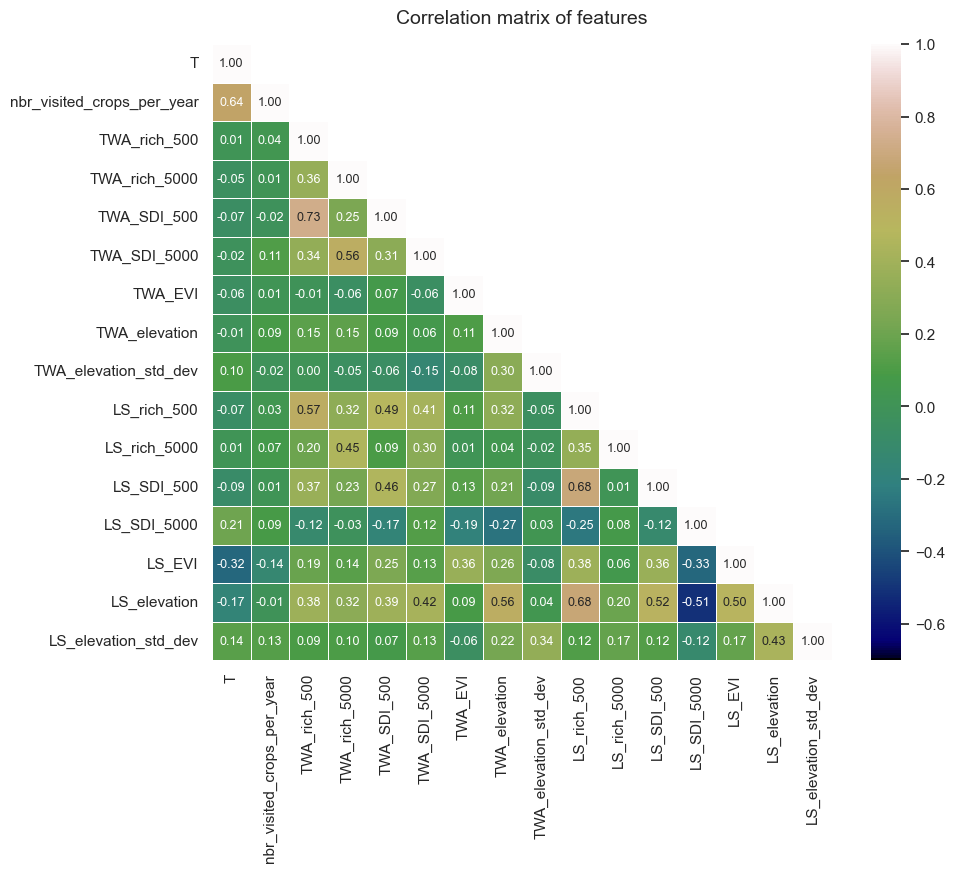

In [1924]:
# creating the corr_matrix
corr_matrix = corr_df.corr()

# creates mask for the upper triangle excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# plot size
plt.figure(figsize=(10, 8))

# plot the corr matrix with sns heatmap
sns.heatmap(corr_matrix, annot=True, cmap='gist_earth', fmt=".2f", linewidths=0.5, mask=mask, annot_kws={"size": 9}, vmin=-.7,vmax=1)

# A
plt.title('Correlation matrix of features', fontsize=14, pad=15)
# plt.tight_layout()

# Save plot
# plt.savefig(r'path\corr_matrix.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


Some features are somewhat correlated. Let's visualize the explained variance in 'T' by using a PCA

## Exploration Principal Component Analysis (PCA)

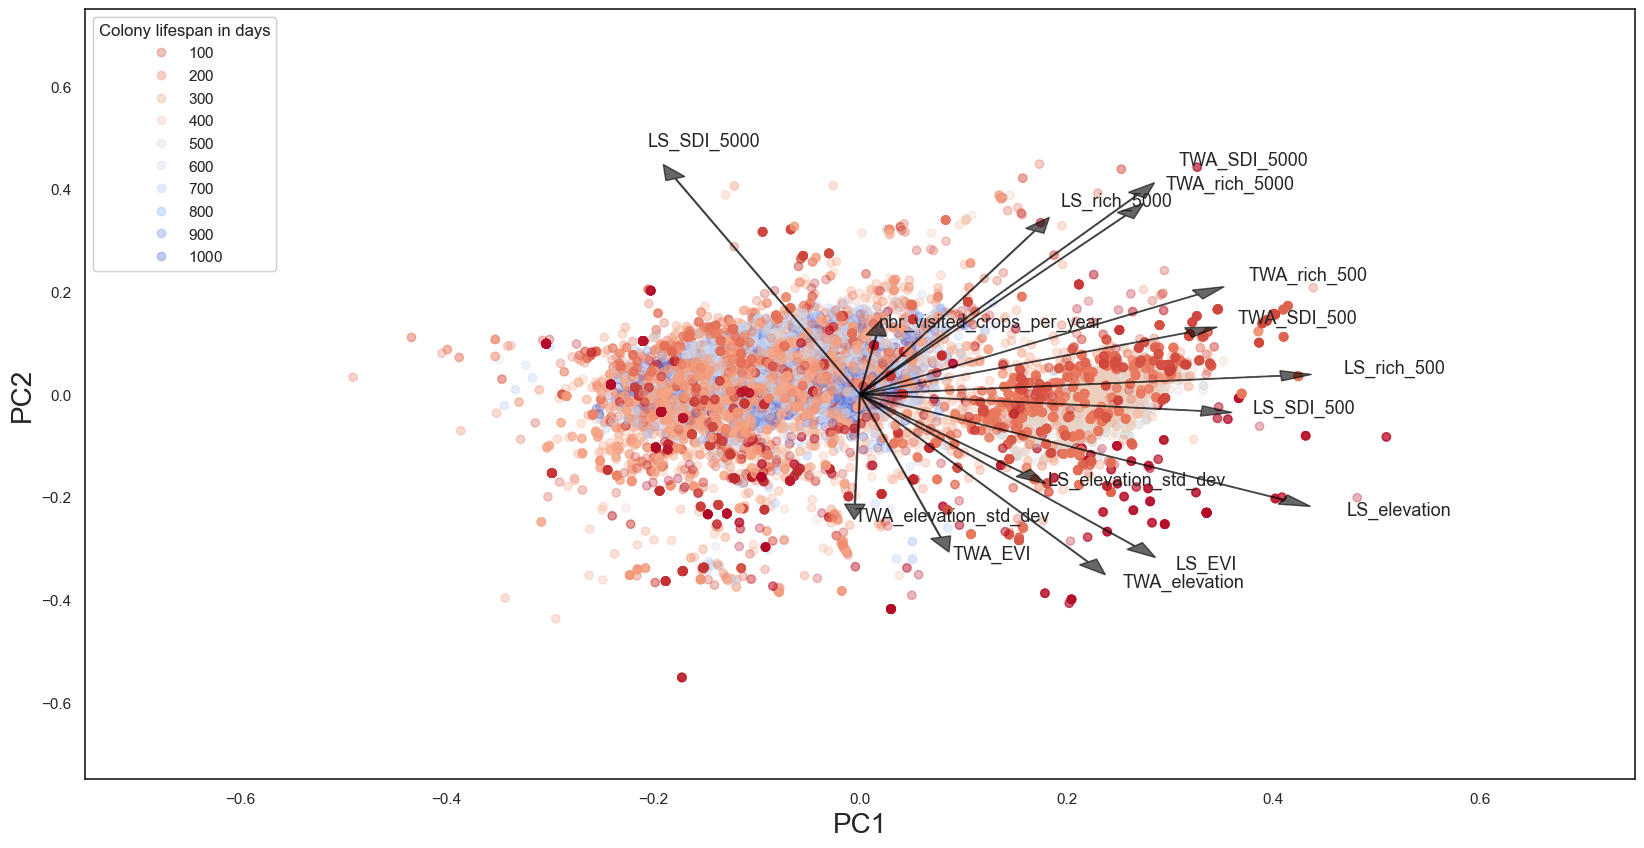

In [1927]:
# PCA with ALL independent features
target = df['T'].to_numpy()
PCA_X = corr_df.drop(columns={'T'})

X_st =  StandardScaler().fit_transform(PCA_X)
pca_out = PCA().fit(X_st)

# component loadings
loadings = pca_out.components_
loadings

# get eigenvalues (variance explained by each PC)
pca_out.explained_variance_


# get biplot
pca_scores = PCA().fit_transform(X_st)

cluster.biplot(cscore=pca_scores, loadings=loadings, labels=PCA_X.columns.values,
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

xs = pca_scores[:, 0]
ys = pca_scores[:, 1]
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

fig, ax = plt.subplots(figsize=(20, 10))

scatter = ax.scatter(xs * scalex, ys * scaley,
                     c=target,
                     cmap='coolwarm_r',
                     alpha=0.3)

texts = []
for i, feature in enumerate(PCA_X.columns):
    ax.arrow(0, 0, pca_out.components_[0, i], pca_out.components_[1, i],
             head_width=0.02, head_length=0.03, color='black', alpha=0.6)
    texts.append(ax.text(pca_out.components_[0, i] * 1.15,
                         pca_out.components_[1, i] * 1.15,
                         feature, fontsize=13, alpha=1))

# adjust_text library allows to prevent label overlap
# adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.4))


ax.set_xlim(-.75, .75)
ax.set_ylim(-.75, .75)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Colony lifespan in days",facecolor='white')
ax.add_artist(legend1)

# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

plt.show()

In [1928]:
print("Explained variance ratio of each principal component:")
print(pca_out.explained_variance_ratio_)

print("Cumulative explained variance:")
print(np.cumsum(pca_out.explained_variance_ratio_))

Explained variance ratio of each principal component:
[0.28548116 0.12623652 0.10683592 0.07813062 0.06933063 0.05854705
 0.05471795 0.05228783 0.04473155 0.03266674 0.02974301 0.026733
 0.01804839 0.00871954 0.00779009]
Cumulative explained variance:
[0.28548116 0.41171768 0.5185536  0.59668422 0.66601485 0.7245619
 0.77927985 0.83156768 0.87629924 0.90896598 0.93870899 0.96544199
 0.98349037 0.99220991 1.        ]


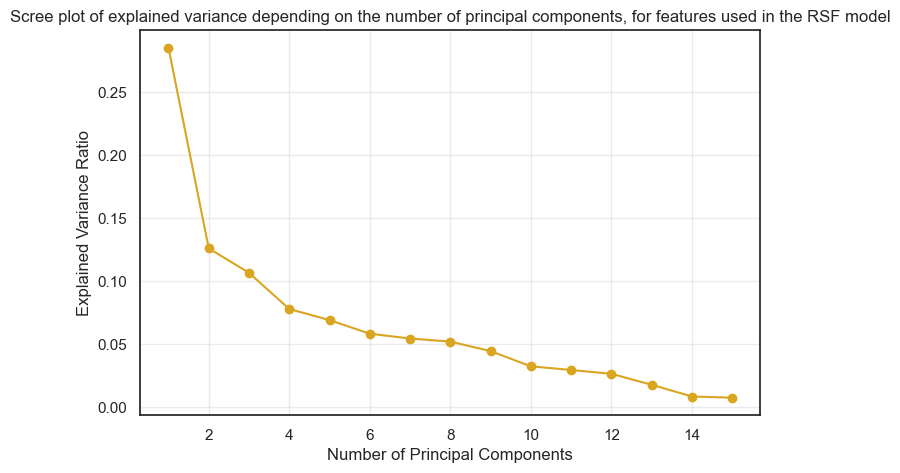

In [1929]:
# variance scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-',color='goldenrod')
plt.grid(True, alpha=0.4)
plt.title('Scree plot of explained variance depending on the number of principal components, \n considering the features used in the RSF model')
plt.xlabel('Number of principal components')
plt.ylabel('Ratio of explained variance')
# plt.savefig(r'path.png',dpi=300,bbox_inches='tight')
plt.show()

# Main analysis section

## Cox time-varying (CTV) model

To run a time-varying survival model, you need to keep all reports. This is why we created df2 before creating df, which has only one report per hive

### Preparing the CTV dataset

Such models typically requires two additional variables: <br> 
* The start and end time specific to each report 
* and event column specific to each report

In [1930]:
# uses df2, a copy() of df which keeps all reports
df2.columns

Index(['hiveID', 'year', 'date', 'operationID', 'is_alive', 'E', 'T',
       'hive_age', 'rich_500', 'rich_1000', 'rich_2500', 'rich_5000',
       'SDI_500', 'SDI_1000', 'SDI_2500', 'SDI_5000', 'evi_apr', 'evi_jul',
       'evi_oct', 'elevation', 'elevation_std_dev', 'time_interval',
       'TWA_rich_500', 'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000',
       'TWA_SDI_500', 'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 'EVI',
       'TWA_EVI', 'TWA_elevation', 'TWA_elevation_std_dev', 'maj_crop_500',
       'maj_crop_1000', 'maj_crop_2500', 'most_visited_crop_500',
       'most_visited_crop_1000', 'most_visited_crop_2500', 'nbr_visited_crops',
       'nbr_visited_crops_per_year'],
      dtype='object')

In [1931]:
# creates an alternate E column. This one is specific to each report (E2) and not to each hive (E)!
df2.loc[:,'E2'] = abs(df2['is_alive'] - 1)

In [1932]:
# Creates the end time column based on the hive_age and the time_interval
df2.loc[:,'end_time'] = df2['hive_age'] + df2['time_interval']

In [1933]:
event_col='E2'
start_col='hive_age'
stop_col='end_time'

In [1934]:
# fix to avoid start col and end col having the same value (same day reports)
df2.loc[:,'end_time'] = df2['end_time'] + 1

### Fitting the model

In [ ]:
# Cox time varying model
ctv = CoxTimeVaryingFitter()

In [1935]:
# Model with Year and operationID grouping variables (to account for beekeeping management practices and yearly weather)
ctv.fit(df2,
        id_col='hiveID',
        event_col='E2',
        start_col='hive_age',
        stop_col='end_time', 
        formula='EVI*rich_1000 + SDI_500 + elevation + elevation_std_dev',
        strata=['year','operationID']
        )

ctv.print_summary(3, model="Year and operationID grouping")

<lifelines.CoxTimeVaryingFitter: fitted with 303951 periods, 34871 subjects, 7932 events>
         event col = 'E2'
            strata = ['year', 'operationID']
number of subjects = 34871
 number of periods = 303951
  number of events = 7932
partial log-likelihood = -49168.319
  time fit was run = 2024-09-11 19:10:40 UTC
             model = Year and operationID grouping

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
EVI               -15.322     0.000     0.366         -16.040         -14.604               0.000               0.000
rich_1000          -0.225     0.798     0.013          -0.250          -0.201               0.779               0.818
SDI_500            -1.527     0.217     0.040          -1.606          -1.447               0.201               0.235
elevation           0.001     1.001     0.000           0.001           0.002               1.001               1.002
elevation_std_dev  -0.024     0.976     0.004          -0.031          -0.017               0.969               0.984
EVI:rich_1000       1.028     2.795     0.031           0.967           1.088               2.630               2.969

                   cmp to       z       p  -log2(p)
covariate                                          
EVI                 0.000 -41.820 <0.0005       inf
rich_1000           0.000 -17.898 <0.0005   235.573
SDI_500             0.000 -37.723 <0.0005  1032.047
elevation           0.000   3.823 <0.0005    12.889
elevation_std_dev   0.000  -6.317 <0.0005    31.806
EVI:rich_1000       0.000  33.186 <0.0005   799.826
---
Partial AIC = 98348.639
log-likelihood ratio test = 4905.157 on 6 df
-log2(p) of ll-ratio test = inf

In [1936]:
# Another model with 'maj_crop_500 grouping variables (to neglect the effect of the crop type!)
ctv.fit(df2,
        id_col='hiveID',
        event_col='E2',
        start_col='hive_age',
        stop_col='end_time', 
        formula='EVI*rich_1000 + SDI_500 + elevation + elevation_std_dev', 
        strata=['maj_crop_500']
        )

ctv.print_summary(3, model="maj_crop_500 grouping")

<lifelines.CoxTimeVaryingFitter: fitted with 303951 periods, 57645 subjects, 7932 events>
         event col = 'E2'
            strata = maj_crop_500
number of subjects = 57645
 number of periods = 303951
  number of events = 7932
partial log-likelihood = -48131.696
  time fit was run = 2024-09-11 19:10:50 UTC
             model = maj_crop_500 grouping

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
EVI               -15.069     0.000     0.421         -15.894         -14.243               0.000               0.000
rich_1000          -0.270     0.764     0.013          -0.295          -0.244               0.744               0.784
SDI_500            -0.795     0.452     0.046          -0.885          -0.705               0.413               0.494
elevation           0.003     1.003     0.000           0.002           0.003               1.002               1.003
elevation_std_dev  -0.027     0.974     0.004          -0.035          -0.018               0.965               0.982
EVI:rich_1000       0.975     2.652     0.035           0.908           1.043               2.478               2.838

                   cmp to       z       p  -log2(p)
covariate                                          
EVI                 0.000 -35.768 <0.0005   928.356
rich_1000           0.000 -20.440 <0.0005   306.065
SDI_500             0.000 -17.343 <0.0005   221.426
elevation           0.000   9.428 <0.0005    67.696
elevation_std_dev   0.000  -6.186 <0.0005    30.597
EVI:rich_1000       0.000  28.209 <0.0005   579.136
---
Partial AIC = 96275.391
log-likelihood ratio test = 3677.330 on 6 df
-log2(p) of ll-ratio test = inf

EVI has a considerable effect. Considering it is scaled from 0 to 1, let's rescale to range so that the effect is in 10% steps.

In [1937]:
# rescaling EVI on a 0 to 10 range
df2['EVI'] = df2['EVI'] * 10

In [1938]:
# Including all three grouping features (crop type, management practices, and yearly weather conditions)
ctv.fit(df2,
        id_col='hiveID',
        event_col='E2',
        start_col='hive_age',
        stop_col='end_time', 
        formula='EVI*rich_1000 + SDI_500 + elevation + elevation_std_dev', 
        strata=['maj_crop_500','operationID','year']
        )

ctv.print_summary(3, model="Final model")

<lifelines.CoxTimeVaryingFitter: fitted with 303951 periods, 79032 subjects, 7932 events>
         event col = 'E2'
            strata = ['maj_crop_500', 'operationID', 'year']
number of subjects = 79032
 number of periods = 303951
  number of events = 7932
partial log-likelihood = -38585.972
  time fit was run = 2024-09-11 19:11:01 UTC
             model = Final model

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
EVI               -1.593     0.203     0.046          -1.683          -1.504               0.186               0.222
rich_1000         -0.262     0.770     0.015          -0.292          -0.232               0.747               0.793
SDI_500           -1.222     0.295     0.053          -1.325          -1.118               0.266               0.327
elevation          0.004     1.004     0.000           0.004           0.005               1.004               1.005
elevation_std_dev -0.024     0.976     0.005          -0.033          -0.015               0.967               0.985
EVI:rich_1000      0.105     1.111     0.004           0.098           0.112               1.103               1.119

                   cmp to       z       p  -log2(p)
covariate                                          
EVI                 0.000 -34.850 <0.0005   881.551
rich_1000           0.000 -17.117 <0.0005   215.777
SDI_500             0.000 -23.126 <0.0005   390.644
elevation           0.000  11.676 <0.0005   102.219
elevation_std_dev   0.000  -5.210 <0.0005    22.340
EVI:rich_1000       0.000  28.241 <0.0005   580.456
---
Partial AIC = 77183.945
log-likelihood ratio test = 3060.080 on 6 df
-log2(p) of ll-ratio test = inf

In [ ]:
# Calculate C-index from the partial hazards
partial_hazards = ctv.predict_partial_hazard(df2)

c_index = concordance_index(df2[stop_col], -partial_hazards, df2[event_col])

c_index

0.743579303821822

In [5]:
surv = Surv.from_dataframe(event_col, stop_col, df2)

times = np.arange(3, 1075, 5)
cox_auc, cox_mean_auc = cumulative_dynamic_auc(surv, surv, partial_hazards, times)

### CTV model outputs

We can plot the CTV model time-dependant AUC

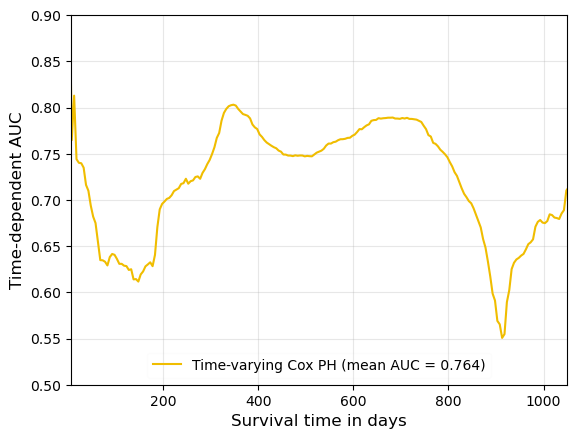

In [ ]:
# Choice of colors for the plot line
colors = ['#05009B', '#003D7A', '#2ca02c','#59007A','#D12900','#79004D','#f0bd00']  

# Plot the AUC curve and label the mean AUC
plt.plot(times, cox_auc, "-", label=f"Time-varying Cox PH (mean AUC = {cox_mean_auc:.3f})", color=colors[6]) #  choose the color by index

# plot parameters
plt.xlabel("Survival time in days", fontsize=12)  
plt.ylabel("Time-dependent AUC", fontsize=12)
plt.xlim(7, 1050)
plt.ylim(0.5, 0.9)
plt.legend(loc="lower center", fontsize=10,framealpha=0.05) 
plt.grid(alpha=0.3)

#save the fig
# plt.savefig(r'path',dpi=300,bbox_inches='tight')


plt.show()

We can also visualize the coefs of the features

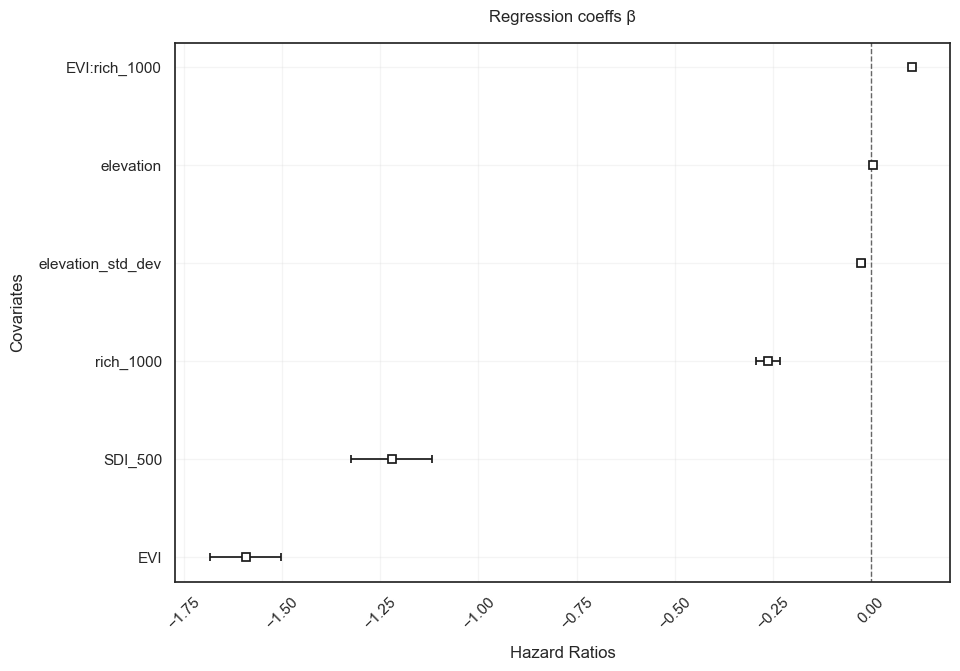

In [1939]:
## Plot the Regression coeff β
fig_verify = plt.figure(figsize=(10,7))
ax = ctv.plot()
plt.title("Regression coeffs β",pad=15)
ax.set_xlabel("Hazard Ratios", fontsize=12,labelpad=10)
ax.set_ylabel("Covariates", fontsize=12,labelpad=10)
plt.grid(True,alpha=0.2)

# Rotate labels for better readability
plt.xticks(rotation=45)

plt.show()

In [ ]:
effect_cox = ctv.summary

# reorder indexes
effect_cox = effect_cox.reindex(['EVI:rich_1000','EVI', 'rich_1000', 'SDI_500', 'elevation', 'elevation_std_dev',
       ])

# rename for plotting
effect_cox.rename(index={'EVI':'Enhanced vegetation index (EVI)',
    'rich_1000':'Richness of land cover or crop types in a 1 000 m radius',
    'SDI_500':'Landscape diversity (SDI) in a 500 m radius',
    'elevation':'Elevation in meters above mean sea level',
    'elevation_std_dev':'Standard deviation of elevation in meters in a 500 m radius',
    'EVI:rich_1000':'Interaction effect: EVI and richness of crop types in a 1 000 m radius'},inplace=True)

effect_cox['coef']

covariate
Enhanced vegetation index (EVI)                                         -1.593476
Richness of crop types in a 1000 m radius                               -0.261557
Landscape diversity in a 500 m radius                                   -1.221547
Elevation in meters above mean sea level                                 0.004288
Standard deviation of elevation in meters in a 300 m radius             -0.024065
Interaction effect: EVI and richness of crop types in a 1000 m radius    0.105119
Name: coef, dtype: float64

In [2366]:
# export model summary
effect_cox.to_csv(r'path\coxtv_summary.csv')

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Enhanced vegetation index (EVI),-1.593476,0.203218,0.045724,-1.683092,-1.503859,0.185799,0.222271,0.0,-34.850156,4.234548e-266,881.550665
Richness of crop types in a 1000 m radius,-0.261557,0.769852,0.015281,-0.291506,-0.231608,0.747137,0.793257,0.0,-17.117001,1.108403e-65,215.776844
Landscape diversity in a 500 m radius,-1.221547,0.294774,0.052821,-1.325076,-1.118019,0.265783,0.326927,0.0,-23.125965,2.537831e-118,390.643919
Elevation in meters above mean sea level,0.004288,1.004297,0.000367,0.003568,0.005007,1.003574,1.005020,0.0,11.675822,1.694192e-31,102.219174
Standard deviation of elevation in meters in a 300 m radius,-0.024065,0.976222,0.004619,-0.033118,-0.015013,0.967425,0.985099,0.0,-5.210431,1.884020e-07,22.339682
Interaction effect: EVI and richness of crop types in a 1000 m radius,0.105119,1.110843,0.003722,0.097824,0.112415,1.102769,1.118977,0.0,28.240869,1.842706e-175,580.455591


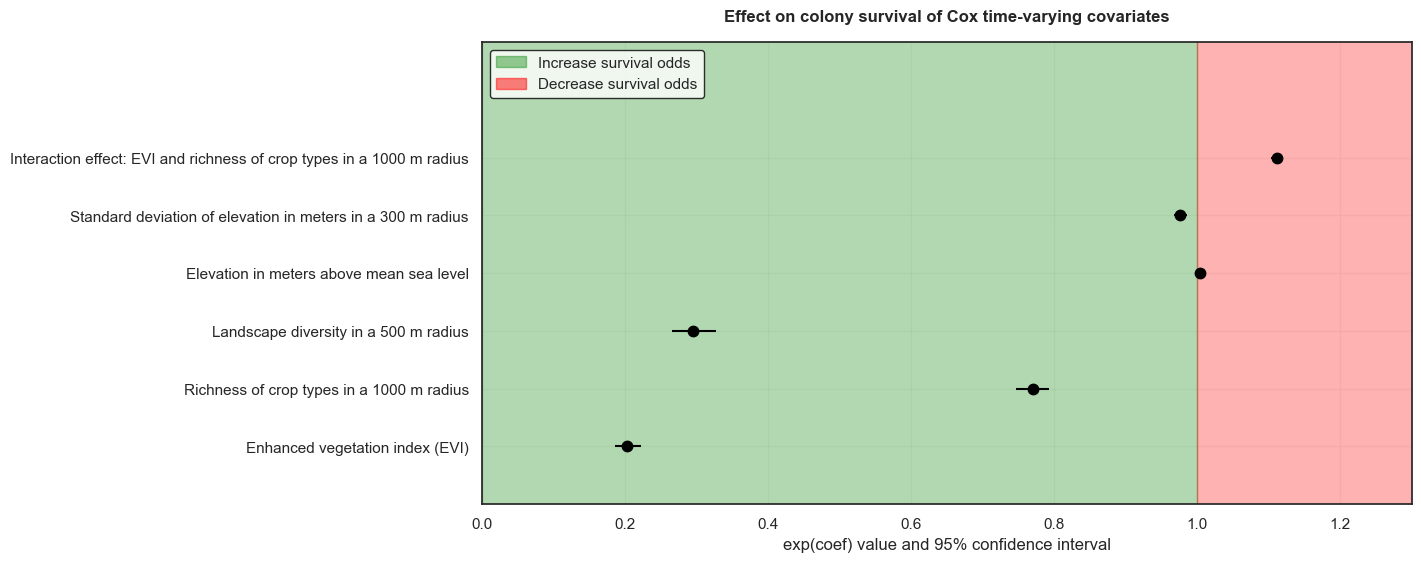

In [2388]:
ce = np.round(np.exp(ctv.confidence_intervals_),2).reset_index()
c = np.round(ctv.hazard_ratios_,2).reset_index()

x = effect_cox.index.values ### covariates
y = effect_cox['exp(coef)'].values
xerr = np.array(list(zip(abs(effect_cox['exp(coef) lower 95%']-effect_cox['exp(coef)'])
                         ,abs(effect_cox['exp(coef) upper 95%']-effect_cox['exp(coef)'])))).T


fig, ax = plt.subplots(figsize=(12,6))
plt.errorbar(y, x, xerr=xerr, fmt='o',color="black",markersize=7.5)
# plt.ylabel("Features")
plt.title("Effect on colony survival of Cox time-varying covariates", fontweight='heavy',pad=15)
plt.xlim(0,1.3)
plt.xlabel('Hazard ratio (exp(coef) value and 95% confidence interval)')
# plt.vlines(1,0,len(x), color="green",lw=4, ls=":")
ax.add_patch(Rectangle((0, -2), 1, 100, color="green", alpha=0.3))
ax.add_patch(Rectangle((1, -2), 100, 100, color="red", alpha=0.3))
ax.set_ylim(-1, len(x) + 1)

red_patch = mpatches.Patch(color='red',alpha=0.5, label='Decrease survival odds')
green_patch = mpatches.Patch(color='green',alpha=0.4, label='Increase survival odds')

# add a legend
plt.legend(handles=[green_patch,red_patch],facecolor='white',frameon=True,edgecolor='black')

plt.grid(alpha=0.2)

# plt.savefig(r'path',dpi=300,bbox_inches='tight')
plt.show()

In [1947]:
## Cumulative Baseline Hazard: Ho(t)
CTV_Baselines = pd.concat([ctv.baseline_cumulative_hazard_,    ## Baseline Cumulative Hazard function: Ho(t)
                           ], axis=1).reset_index()

CTV_Baselines.columns = ['Last_cycle',
                         'Ho',
                          ]

print(" \n CTV_Baselines = \n", CTV_Baselines)

 
 CTV_Baselines = 
      Last_cycle        Ho
0             2  0.000229
1             3  0.001810
2             4  0.002531
3             5  0.002725
4             6  0.003020
..          ...       ...
793        1074  5.110483
794        1075  5.133662
795        1076  5.160806
796        1077  5.216819
797        1078  5.405764

[798 rows x 2 columns]


## Scatterplots

In [1949]:
df.columns

Index(['hiveID', 'year', 'date', 'operationID', 'is_alive', 'E', 'T',
       'hive_age', 'LS_rich_500', 'LS_rich_1000', 'LS_rich_2500',
       'LS_rich_5000', 'LS_SDI_500', 'LS_SDI_1000', 'LS_SDI_2500',
       'LS_SDI_5000', 'LS_EVI_apr', 'LS_EVI_jul', 'LS_EVI_oct', 'LS_elevation',
       'LS_elevation_std_dev', 'time_interval', 'TWA_rich_500',
       'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000', 'TWA_SDI_500',
       'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 'LS_EVI', 'TWA_EVI',
       'TWA_elevation', 'TWA_elevation_std_dev', 'maj_crop_500',
       'maj_crop_1000', 'maj_crop_2500', 'most_visited_crop_500',
       'most_visited_crop_1000', 'most_visited_crop_2500', 'nbr_visited_crops',
       'nbr_visited_crops_per_year'],
      dtype='object')

### E=0 vs E=1 at last visited locations

The goal here is two compare the landscape for two groups: 
1. Colonies that have been last reported alive (Event E = 0)
2. Colonies that have been last reported dead (Event E = 1)

Here, we ask: "are locations which have *caused colony failure* different that those which *keep colonies alive*?"

In [1950]:
# Create two subsets of df based on the event
df_e1 = df[df['E'] == 1]
df_e0 = df[df['E'] == 0]

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_4900\3477945181.py:23: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_4900\3477945181.py:24: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_4900\3477945181.py:23: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgre

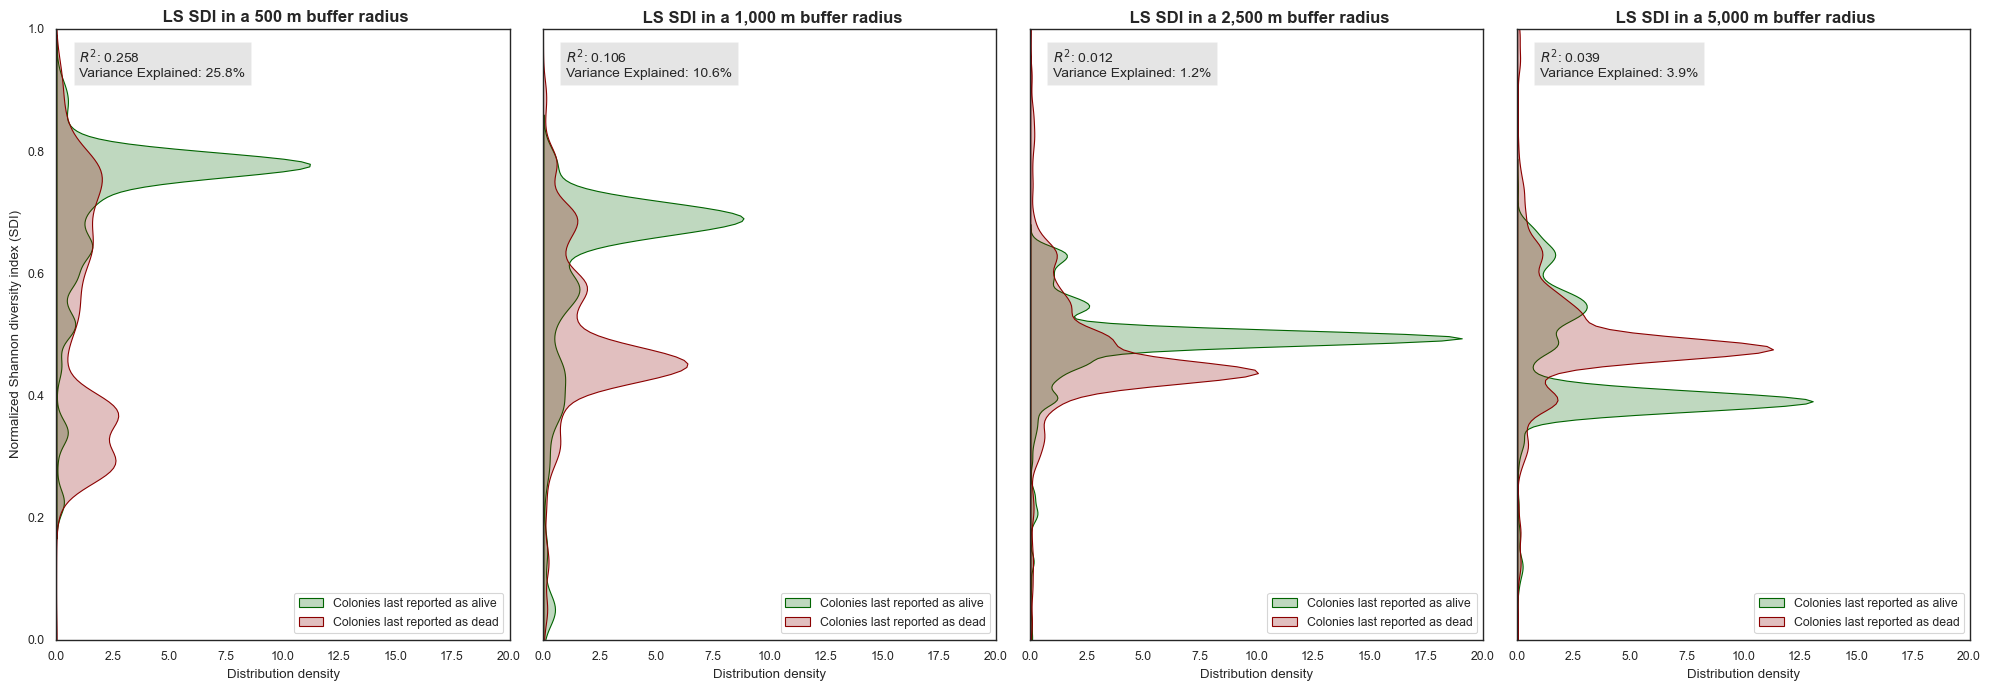

In [ ]:
# List of columns to plot
columns = ['LS_SDI_500','LS_SDI_1000','LS_SDI_2500', 'LS_SDI_5000'] 
 
# Dictionary for title
radius_dict = {
    'LS_SDI_500':'500 m','LS_SDI_1000':'1,000 m','LS_SDI_2500':'2,500 m','LS_SDI_5000':'5,000 m'
}

# Number of columns in the grid
n_cols = 4
n_rows = len(columns) // n_cols + int(len(columns) % n_cols > 0)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(columns):
    # Perform the Mann-Whitney U test
    u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])
    
    # Create the distribution plot with density on x and column on y
    sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
    sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
    
    # Retrieve radius for title
    radius = radius_dict.get(col, col)  

    # Add labels and title
    axes[i].set_title(f' LS SDI in a {radius} buffer radius', fontsize=12, fontweight='bold', pad=5)
    axes[i].set_xlabel('Distribution density')
    axes[i].set_ylabel("Normalized Shannon diversity index (SDI)")
    axes[i].legend(loc='lower right',facecolor='white')
    
    # Compute R^2 and percentage of variance explained with linear regression
    X = df[[col]].values
    y = df['E'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    variance_explained = r2 * 100
    
    # Annotate the plot with Mann-Whitney U test results, R^2, and variance explained
    annotation_text = (
        # f'Mann-Whitney test:\n'
        #        f'distributions are different with p <= {u_p_value:.3f}\n' # Uncomment for true value (p = 0.0000 is showed)
        #     # f'Distributions are different with p < 0.001\n'
            f'$R^2$: {r2:.3f}\n'
            f'Variance Explained: {variance_explained:.1f}%')
    axes[i].text(0.05, 0.97, annotation_text, transform=axes[i].transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

plt.ylim(0,1)
# tight layout
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)


plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\2929400784.py:25: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\2929400784.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\2929400784.py:25: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='dark

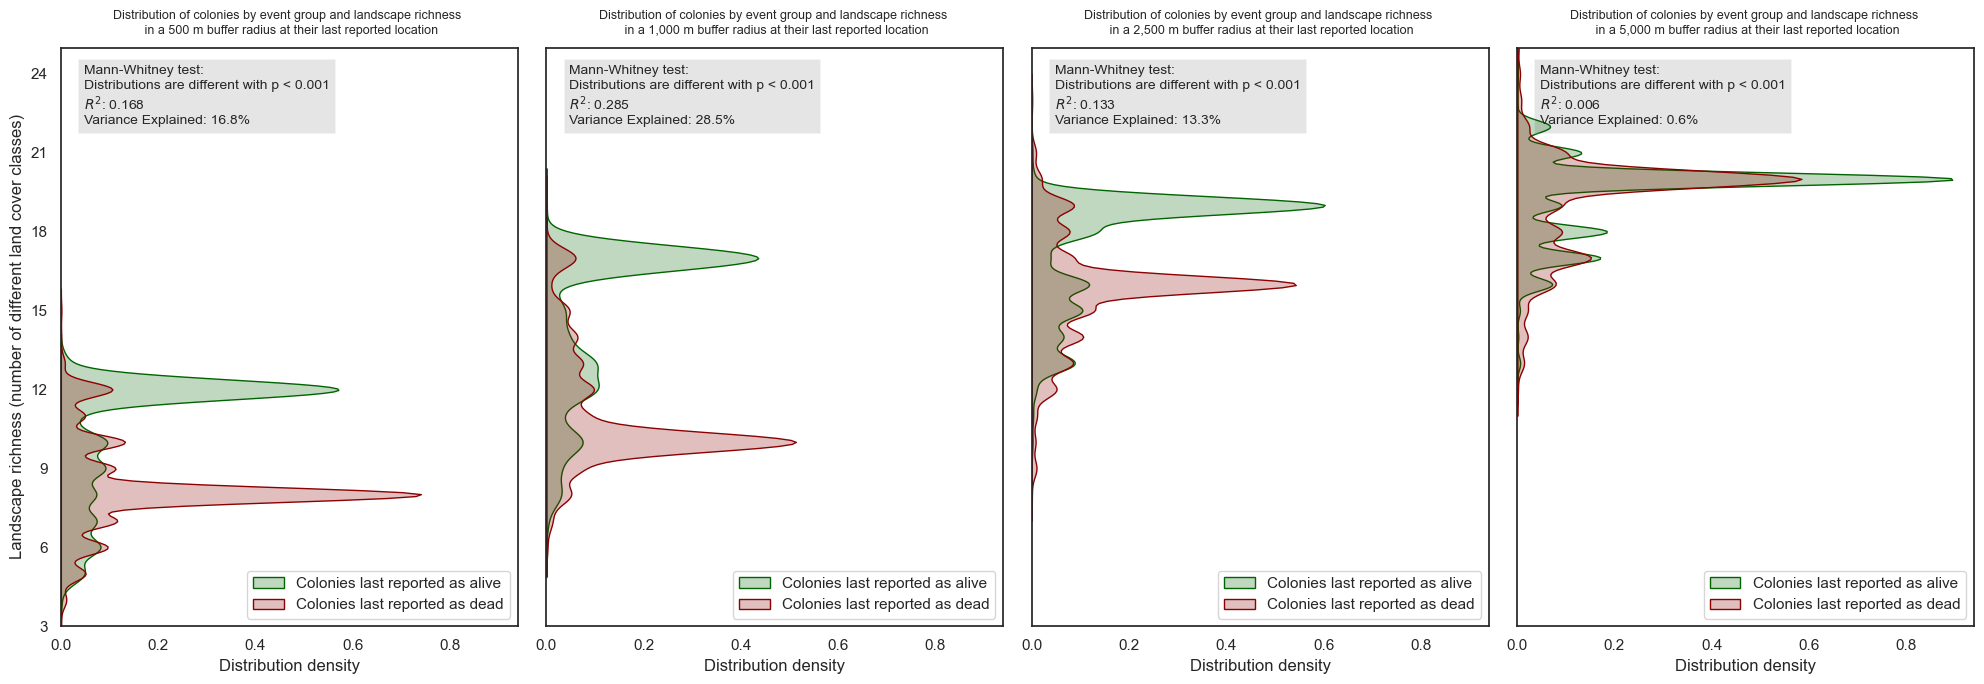

In [1952]:
# List of columns to plot
columns = ['LS_rich_500', 'LS_rich_1000','LS_rich_2500', 'LS_rich_5000']

# Define a dictionary to map column names to radius labels
radius_dict = {
    'LS_rich_500':'500 m','LS_rich_1000':'1,000 m','LS_rich_2500':'2,500 m','LS_rich_5000':'5,000 m'
}

# Number of columns in the grid
n_cols = 4
n_rows = len(columns) // n_cols + int(len(columns) % n_cols > 0)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(columns):
    # Perform the Mann-Whitney U test
    u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])
    
    # Create the distribution plot with density on x and column on y
    sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
    sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
    
    # Retrieve radius for title
    radius = radius_dict.get(col, col)  
    
    # Add labels and title
    axes[i].set_title(f'Distribution of colonies by event group and landscape richness \n in a {radius} buffer radius at their last reported location', fontsize=9, pad=10)
    axes[i].set_xlabel('Distribution density')
    axes[i].set_ylabel('Landscape richness (number of different land cover classes)')
    axes[i].legend(loc='lower right',facecolor='white')
    
    # Compute R^2 and percentage of variance explained with linear regression
    X = df[[col]].values
    y = df['E'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    variance_explained = r2 * 100
    
    # Annotate the plot with Mann-Whitney U test results, R^2, and variance explained
    annotation_text = (f'Mann-Whitney test:\n'
            #    f'distributions are different with p <= {u_p_value:.3f}\n' # Uncomment for true value (p = 0.0000 is showed)
            f'Distributions are different with p < 0.001\n'
            f'$R^2$: {r2:.3f}\n'
            f'Variance Explained: {variance_explained:.1f}%')
    axes[i].text(0.05, 0.97, annotation_text, transform=axes[i].transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))
# Set y-axis limits and ticks
    axes[i].set_ylim(max(0, np.floor(3)), np.ceil(25))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure y-ticks are integers

# tight layout
plt.tight_layout()

# save fig
# plt.savefig(r'path',dpi=300)

plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\321026913.py:20: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\321026913.py:21: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)


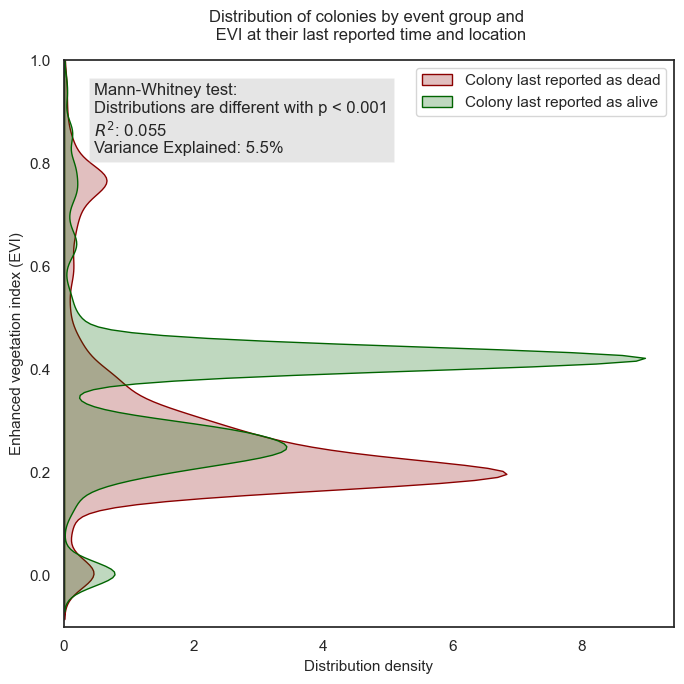

In [1953]:
# Plot column
col = 'LS_EVI'

# Perform the Mann-Whitney U test
u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])

# Compute R^2 and percentage of variance explained with linear regression
X = df[[col]].values
y = df['E'].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
variance_explained = r2 * 100

# Create the distribution plot
plt.figure(figsize=(7, 7))
sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)

# Add labels and title
plt.title(f'Distribution of colonies by event group and \n EVI at their last reported time and location', fontsize=12, pad=15)
plt.xlabel('Distribution density', fontsize=11)
plt.ylabel('Enhanced vegetation index (EVI)', fontsize=11)
plt.ylim(-.1,1)
plt.legend(fontsize=11, facecolor='white')

# add the mann-whitney and the r2 test results
annotation_text = (f'Mann-Whitney test:\n'
                #    f'distributions are different with p <= {u_p_value:.3f}\n' # Uncomment for true value (p = 0.0000 is showed)
                f'Distributions are different with p < 0.001\n'
                f'$R^2$: {r2:.3f}\n'
                f'Variance Explained: {variance_explained:.1f}%')
plt.text(0.05, 0.96, annotation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

# Show the plot
plt.tight_layout()

# save fig
# plt.savefig(r'path',dpi=300)

plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\29068562.py:25: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\29068562.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)


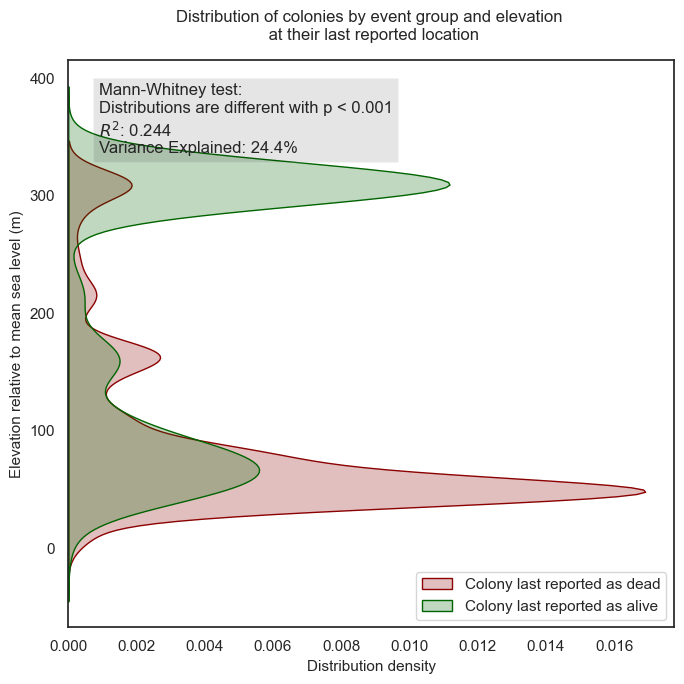

In [1954]:
# Plot column
col = 'LS_elevation'

# Perform the Mann-Whitney U test
u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])

# Compute R^2 and percentage of variance explained with linear regression
X = df[[col]].values
y = df['E'].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
variance_explained = r2 * 100

# Create the distribution plot
plt.figure(figsize=(7, 7))
sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)

# Add labels and title
plt.title(f'Distribution of colonies by event group and elevation \n at their last reported location', fontsize=12, pad=15)
plt.xlabel('Distribution density', fontsize=11)
plt.ylabel('Elevation relative to mean sea level (m)', fontsize=11)
# plt.ylim(-2,20)
plt.legend(fontsize=11,loc='lower right',facecolor='white')

# add the mann-whitney and the r2 test results
annotation_text = (f'Mann-Whitney test:\n'
                #    f'distributions are different with p <= {u_p_value:.3f}\n' # Uncomment for true value (p = 0.0000 is showed)
                f'Distributions are different with p < 0.001\n'
                f'$R^2$: {r2:.3f}\n'
                f'Variance Explained: {variance_explained:.1f}%')
plt.text(0.05, 0.96, annotation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

# Show the plot
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)

plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\4067059308.py:20: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_14556\4067059308.py:21: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)


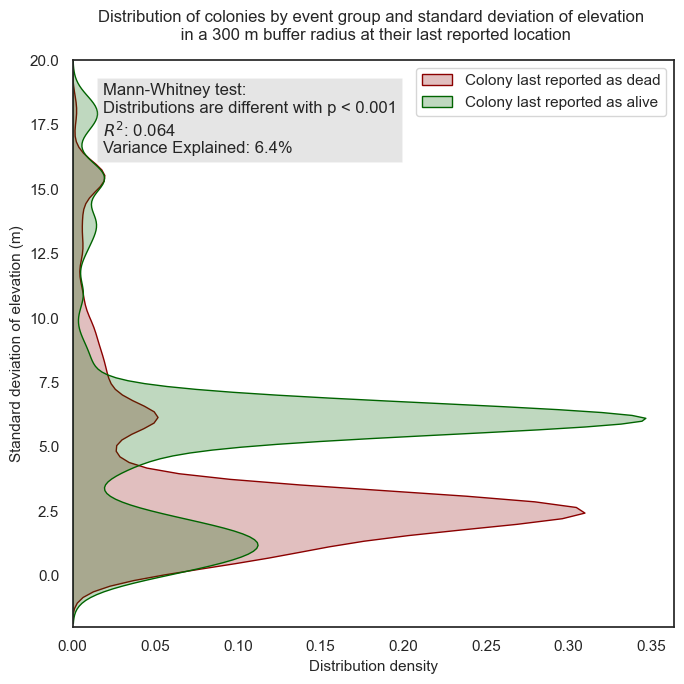

In [1955]:
# Plot column
col = 'LS_elevation_std_dev'

# Create subsets based on 'E' values
df_e1 = df[df['E'] == 1]
df_e0 = df[df['E'] == 0]

# Perform the Mann-Whitney U test
u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])

# Compute R^2 and percentage of variance explained with linear regression
X = df[[col]].values
y = df['E'].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
variance_explained = r2 * 100

# Create the distribution plot
plt.figure(figsize=(7, 7))
sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)

# Add labels and title
plt.title(f'Distribution of colonies by event group and standard deviation of elevation \n in a 300 m buffer radius at their last reported location', fontsize=12, pad=15)
plt.xlabel('Distribution density', fontsize=11)
plt.ylabel('Standard deviation of elevation (m)', fontsize=11)
plt.ylim(-2,20)
plt.legend(fontsize=11,facecolor='white')

# add the mann-whitney and the r2 test results
annotation_text = (f'Mann-Whitney test:\n'
                #    f'distributions are different with p <= {u_p_value:.3f}\n' # Uncomment for true value (p = 0.0000 is showed)
                f'Distributions are different with p < 0.001\n'
                f'$R^2$: {r2:.3f}\n'
                f'Variance Explained: {variance_explained:.1f}%')
plt.text(0.05, 0.96, annotation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

# Show the plot
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)

plt.show()


### Crop maj plots

Local dominant crop. 500 m buffer radius

In [2121]:
# Add synthetic variance to the cranberry group to enhance the following kernel distribution plot 
n = 48

np.random.seed(n) # random seed to allow reproduction
variance_increase = 2.3 # factor

cranberry_mask = df['most_visited_crop_500'] == 'Cranberry'
cranberry_values = df.loc[cranberry_mask, 'T']

# Calculate synthetic variance from initial variance
synthetic_variance = variance_increase * np.var(cranberry_values)

# Generate gaussian synthetic noise around the median
synthetic_noise = np.random.normal(n, np.sqrt(synthetic_variance), size=cranberry_values.shape[0])
synthetic_noise = np.round(synthetic_noise).astype(int)

df.loc[cranberry_mask, 'T'] = df.loc[cranberry_mask, 'T'] + synthetic_noise

df[df['most_visited_crop_500']=='Cranberry']['T'].min() # make sure the minimum T stays positive

2

In [2279]:
# Calculate the mean of 'days_alive' for each 'most_time_spent_crop'
mean_days_alive = df.groupby('most_visited_crop_500')['T'].mean().sort_values()

mean_days_alive


most_visited_crop_500
Cranberry               90.170455
Cereal crops           220.569817
Maize                  222.579950
Other oilseed crops    224.311111
Canola                 253.142857
Water                  298.666667
Urban                  341.783394
Wetland                342.185185
Coniferous             362.528736
Mixed forest           365.497241
Deciduous              389.573067
Pastures               399.147033
Soybean                406.206797
Blueberry              479.643110
Orchard                535.725240
Name: T, dtype: float64

In [2123]:
# Defines a custom order of crops following the order by mean days alive
custom_order = mean_days_alive.index.to_list()
custom_order.reverse()
custom_order

['Orchard',
 'Blueberry',
 'Soybean',
 'Pastures',
 'Deciduous',
 'Mixed forest',
 'Coniferous',
 'Wetland',
 'Urban',
 'Water',
 'Canola',
 'Other oilseed crops',
 'Maize',
 'Cereal crops',
 'Cranberry']

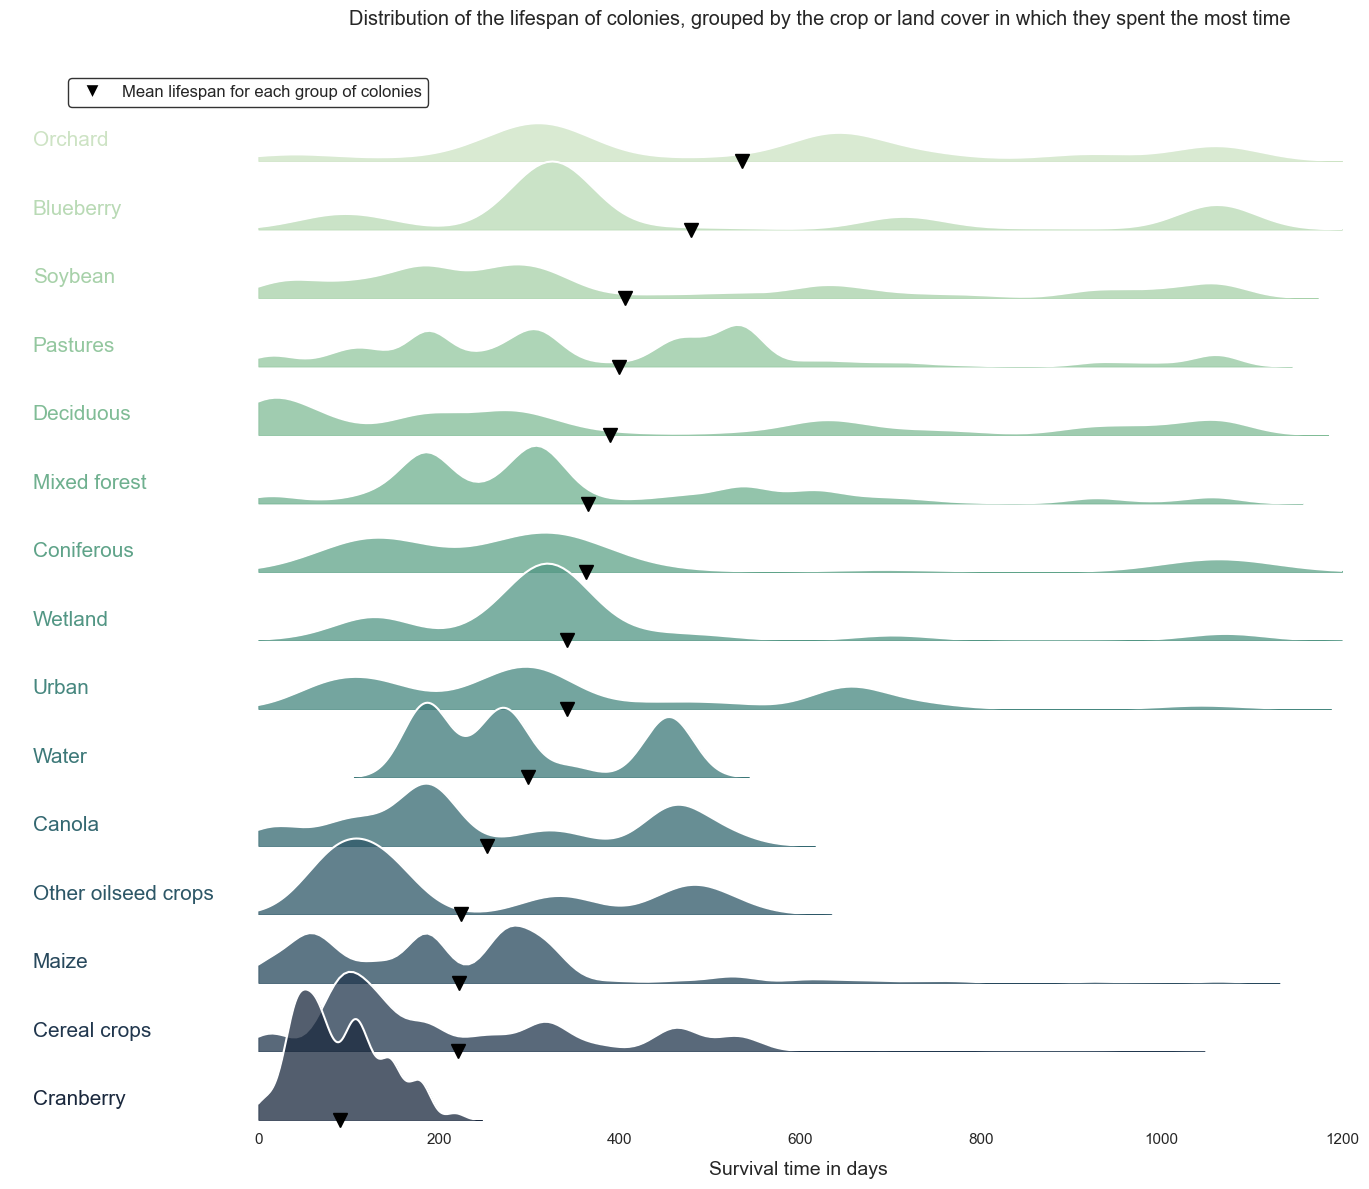

In [2125]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

bw = 0.5 # Distribution shape parameter (bandwidth)

# creates a seaborn cubehelix palette for the number of classes
pal = sns.cubehelix_palette(len(custom_order), 3, rot=-0.47, light=0.85)
g = sns.FacetGrid(df, row='most_visited_crop_500', hue='most_visited_crop_500',
                  aspect=18, height=0.8, palette=pal, row_order=custom_order, hue_order=custom_order)

# Seaborn kernel densities plot
g.map(sns.kdeplot, "T", bw_adjust=bw, clip=(0, 1200), fill=True, alpha=.75, linewidth=.5)
g.map(sns.kdeplot, "T", clip=(0, 1200), color="w", lw=1.5, bw_adjust=bw)

# Simple function to label the plot in axes coordinates and add a marker at the mean
def label_and_marker(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.15, label, color=color, ha="left", va="center", transform=ax.transAxes, fontsize=15)
    mean_value = mean_days_alive[label]
    ax.plot(mean_value, 0, marker="v", markersize=10, color='black', clip_on=False)

# Apply the label and marker function
g.map(label_and_marker, 'T')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.5)
g.set_xlabels('Survival time in days', fontsize=14, labelpad=10, x=0.585) 
g.set_ylabels('Dominant crop type/land cover')

# Set x-axis limits
g.set(xlim=(-250, 1200))  # Update the lower limit to 0 to ensure only positive values are shown

# Remove x-axis labels below 0
for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks()[ax.get_xticks() >= 0])
    # ax.margins(x=0.5)

# Add a title to the figure
g.figure.suptitle('Distribution of the lifespan of colonies, grouped by the crop or land cover in which they spent the most time')

# Remove axes details that overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Create custom legend
legend_elements = [Line2D([0], [0], marker='v', color='w', label='Mean lifespan for each group of colonies',
                          markerfacecolor='black', markersize=10, linestyle='None')]

# Add the custom legend to the plot
g.add_legend(handles=legend_elements, title="", loc=(0.05, 0.91), frameon=True, edgecolor='black', facecolor='none', fontsize=12)

# export fig
# plt.savefig(r'path.png',dpi=300)

# Show the plot
plt.show()


In [2134]:
grouped_df = df.groupby('most_visited_crop_500').agg(
    mean_days_alive=pd.NamedAgg(column='T', aggfunc='mean'),
    median_days_alive=pd.NamedAgg(column='T', aggfunc='median'),
    stddev_days_alive=pd.NamedAgg(column='T', aggfunc='std'),
    count=pd.NamedAgg(column='T', aggfunc='size')
).reset_index().round(0)

# Table for each crop group
grouped_df.columns = ['Group', 'Mean', 'Median', 'Std dev', 'Hive count']
grouped_df = grouped_df.sort_values('Mean')

grouped_df.to_csv(r'd:\JV\my_papers\diversity-evi-crops\crop_group_table.csv',sep=';')
grouped_df

,Group,Mean,Median,Std dev,Hive count
4,Cranberry,90.0,82.0,49.0,88
2,Cereal crops,221.0,149.0,159.0,709
6,Maize,223.0,188.0,176.0,1207
9,Other oilseed crops,224.0,141.0,162.0,45
1,Canola,253.0,188.0,160.0,91
13,Water,299.0,277.0,109.0,42
12,Urban,342.0,296.0,232.0,277
14,Wetland,342.0,320.0,206.0,81
3,Coniferous,363.0,293.0,305.0,87
7,Mixed forest,365.0,304.0,235.0,1631


In [2136]:
# Generate a descriptive table of each df feature
descriptive_table = df.describe(percentiles=[.5]).T[['mean','50%','std','min','max',]].rename(columns={'50%':'median'})

# export
# descriptive_table.to_csv(r'path.csv',sep=';')

descriptive_table


,mean,median,std,min,max
hiveID,97070.366705,79233.500000,73055.969408,12449.000000,273886.000000
year,2023.076838,2023.000000,0.811744,2021.000000,2024.000000
operationID,105.971743,55.000000,59.384449,55.000000,224.000000
is_alive,0.541054,1.000000,0.498326,0.000000,1.000000
E,0.458946,0.000000,0.498326,0.000000,1.000000
T,377.897800,303.000000,292.063998,1.000000,1076.000000
hive_age,378.382050,303.500000,292.291211,1.000000,1077.000000
LS_rich_500,9.355067,9.000000,2.272337,2.000000,15.000000
LS_rich_1000,12.969137,12.000000,3.143402,6.000000,19.000000
LS_rich_2500,16.612681,16.000000,2.236783,8.000000,23.000000


### Nbr of visited crops vs T

We can also have a look at the distribution of crops based on the number of different crops they visited during the year. <br>
We must create a subset of the dataset to consider only hives which have been reported dead **and** who lived for at least one year including wintering (365 days). <br> <br>
*Otherwise, young hives and rapid mortality make huge bias for the first group (1 crop)*

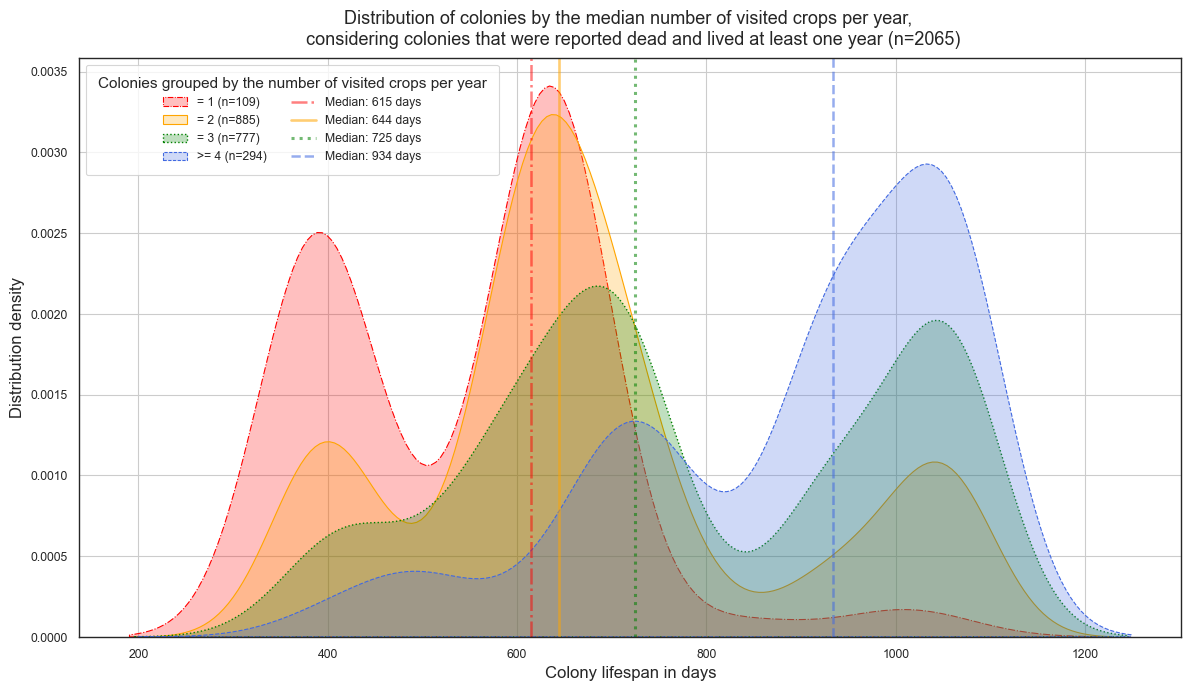

In [ ]:
# Creates a copy of df but only considering colonies who lived at least a year
df_minT = df[df['T'] >= 365]
df_minT = df_minT[df_minT['E'] == 1]

# Plt figure
plt.figure(figsize=(12, 7))

# Define groups
gr1 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) == 1]['T']
gr2 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) == 2]['T']
gr3 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) == 3]['T']
gr4 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) >= 4]['T']

# KDE Plot for distribution
sns.kdeplot(gr1, label=f'= 1 (n={len(gr1)})', fill=True, color='red', linestyle='-.')
sns.kdeplot(gr2, label=f'= 2 (n={len(gr2)})', fill=True, color='orange', linestyle='-')
sns.kdeplot(gr3, label=f'= 3 (n={len(gr3)})', fill=True, linewidth=1, color='green', linestyle=':')
sns.kdeplot(gr4, label=f'>= 4 (n={len(gr4)})', fill=True, color='royalblue', linestyle='--')

# Add vertical lines for the median of each group
plt.axvline(gr1.median(), color='red', linestyle='-.', linewidth=1.8, label=f'Median: {gr1.median():.0f} days',alpha=.5)
plt.axvline(gr2.median(), color='orange', linestyle='-', linewidth=1.9, label=f'Median: {gr2.median():.0f} days',alpha=.55)
plt.axvline(gr3.median(), color='green', linestyle=':', linewidth=2.2, label=f'Median: {gr3.median():.0f} days',alpha=.55)
plt.axvline(gr4.median(), color='royalblue', linestyle='--', linewidth=1.8, label=f'Median: {gr4.median():.0f} days',alpha=.55)

# Plot settings
plt.title(f'Distribution of colonies by the median number of visited crops per year, \n considering colonies that were reported dead and lived at least one year (n={len(df_minT)})', fontsize=13, pad=10)
plt.xlabel('Colony lifespan in days', fontsize=12)
plt.ylabel('Distribution density', fontsize=12)
plt.legend(title='Colonies grouped by the number of visited crops per year', title_fontsize=11, ncol=2, borderpad=1)
plt.grid(True,alpha=0.5)
plt.tight_layout()

# Export
# plt.savefig(r'path', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
sns.reset_defaults()

## RSF

In the RSF, we will use the TWA features. We can't really use the Last seen (LS) metrics as those only apply in the last location visited by the hive. <br>
Also, we chose to not include features such as 'operationID' and 'year' since the goal is to focus on habitat and foraging landscape metrics.

In [ ]:
df.columns

Index(['hiveID', 'year', 'date', 'operationID', 'is_alive', 'E', 'T',
       'hive_age', 'LS_rich_500', 'LS_rich_1000', 'LS_rich_2500',
       'LS_rich_5000', 'LS_SDI_500', 'LS_SDI_1000', 'LS_SDI_2500',
       'LS_SDI_5000', 'LS_EVI_apr', 'LS_EVI_jul', 'LS_EVI_oct', 'LS_elevation',
       'LS_elevation_std_dev', 'time_interval', 'TWA_rich_500',
       'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000', 'TWA_SDI_500',
       'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 'LS_EVI', 'TWA_EVI',
       'TWA_elevation', 'TWA_elevation_std_dev', 'maj_crop_500',
       'maj_crop_1000', 'maj_crop_2500', 'most_visited_crop_500',
       'most_visited_crop_1000', 'most_visited_crop_2500', 'nbr_visited_crops',
       'nbr_visited_crops_per_year'],
      dtype='object')

### Baseline RSF model

We define the columns for a general model

In [2137]:
rsfcol = [
    # 'LS_sdi_500', 'LS_sdi_2500', 'LS_sdi_5000', 'LS_EVI' # see coments above, it would be wrong to use these
    # we let aside the metrics at 1000 and 2500 m to avoid multicollinearity
    'TWA_rich_500','TWA_rich_5000',
    'TWA_SDI_500','TWA_SDI_5000',
    'TWA_EVI','TWA_elevation','TWA_elevation_std_dev',
    'nbr_visited_crops_per_year'
    ]

We split the the data using a 70/30 training/testing ratio

In [2138]:
# RSF model
X = df[rsfcol]
T = df['T'].astype(int)
E = df['E'].astype(int)

# Combine 'Years' and 'E' into a structured array for survival analysis
y = Surv.from_arrays(E, T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=E, random_state=1) # Recommended by 

# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=1, max_depth=10, min_samples_leaf=1 # 200 trees = 8.5 mins 
                        #   ,max_features='sqrt'
                           )

rsf.fit(X_train,y_train)
rsf.score(X_test,y_test)

0.8329752446419045

The accuracy is good, but the model is not optimal in assessing feature importance because of high collinearity between richness and SDI features. Perhaps we can use PCA again to reduce dimensionality between these two groups of features

### RSF + PCA

Using a PCA, we can now add the metrics at all computed scales (500-1000-2500-5000 m)

#### Diversity PCA

In [2177]:
# Diversity columns to reduce dimensionality
pca_cols = ['TWA_SDI_500', 'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 
                     'TWA_rich_500', 'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000']

We can load and plot this two way PCA

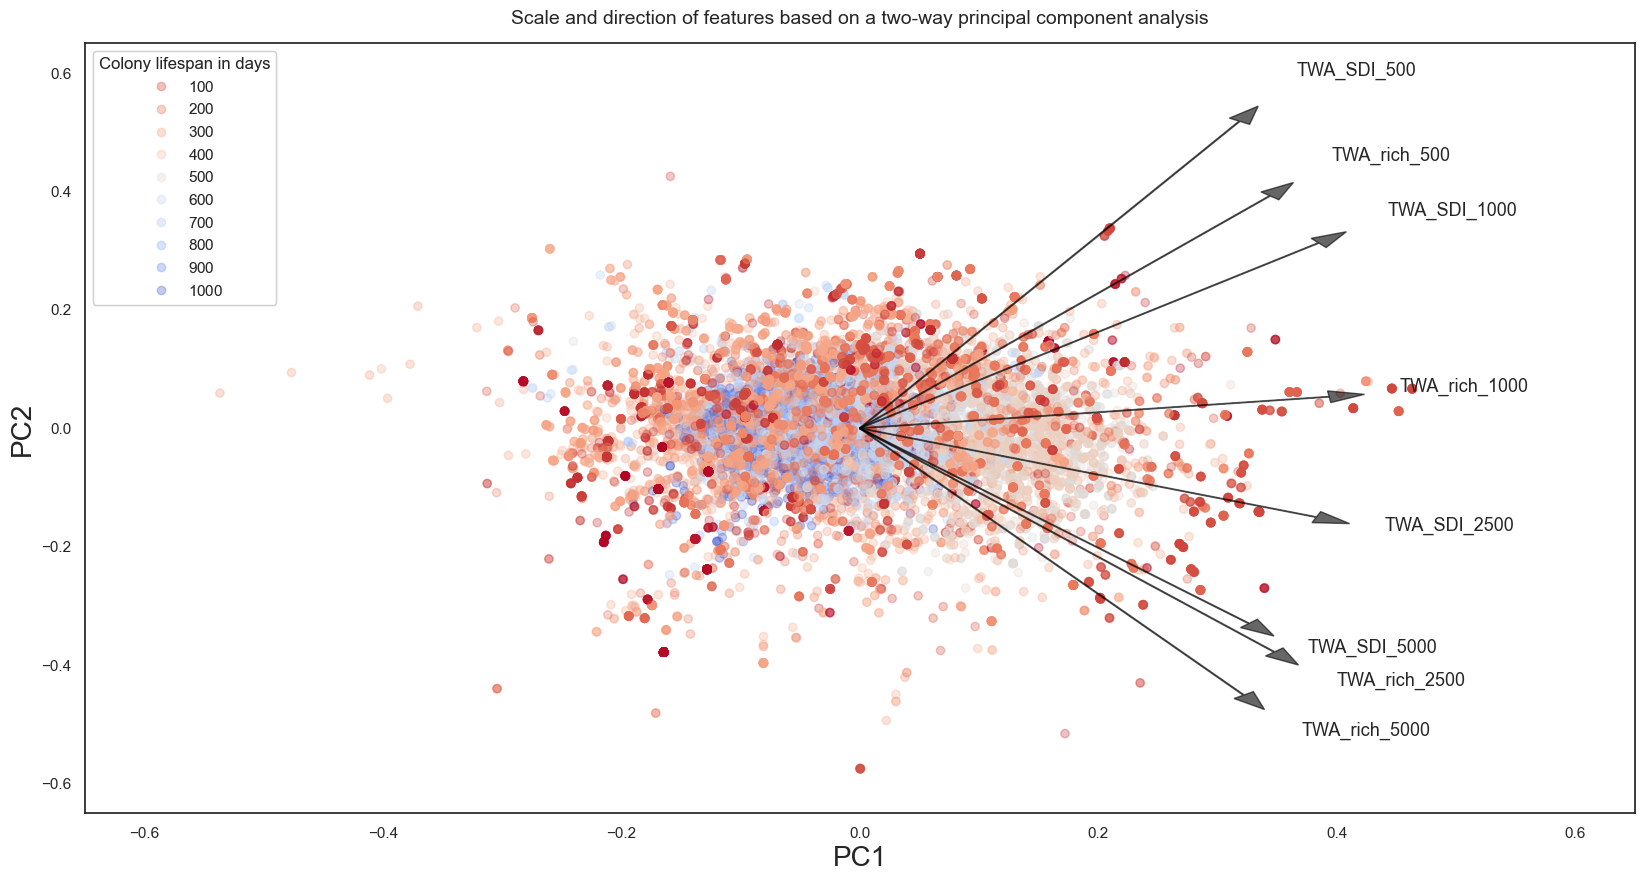

In [2171]:
# PCA
target = df['T'].to_numpy()
PCA_X = df[pca_cols]

X_st =  StandardScaler().fit_transform(PCA_X)
pca_out = PCA().fit(X_st)

# component loadings
loadings = pca_out.components_

# get eigenvalues (variance explained by each PC)
pca_out.explained_variance_


# get biplot
pca_scores = PCA().fit_transform(X_st)

cluster.biplot(cscore=pca_scores, loadings=loadings, labels=PCA_X.columns.values,
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

xs = pca_scores[:, 0]
ys = pca_scores[:, 1]
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

fig, ax = plt.subplots(figsize=(20, 10))

scatter = ax.scatter(xs * scalex, ys * scaley,
                     c=target,
                     cmap='coolwarm_r',
                     alpha=0.3)

texts = []
for i, feature in enumerate(PCA_X.columns):
    ax.arrow(0, 0, pca_out.components_[0, i], pca_out.components_[1, i],
             head_width=0.02, head_length=0.03, color='black', alpha=0.6)
    texts.append(ax.text(pca_out.components_[0, i] * 1.15,
                         pca_out.components_[1, i] * 1.15,
                         feature, fontsize=13, alpha=1))

# adjust_text library allows to prevent label overlap
# adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.4))


ax.set_xlim(-.65, .65)
ax.set_ylim(-.65, .65)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
plt.title('Scale and direction of features based on a two-way principal component analysis', pad=14,fontsize=14)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Colony lifespan in days",facecolor='white')
ax.add_artist(legend1)

# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

plt.show()

In [2175]:
# explained variance ratio
explained_variance_ratio = pca_out.explained_variance_ratio_

print("Explained variance ratio of each principal component:")
print(pca_out.explained_variance_ratio_)

# cumulative explained variance
print("Cumulative explained variance:")
print(np.cumsum(pca_out.explained_variance_ratio_))

Explained variance ratio of each principal component:
[0.61699233 0.16432055 0.0949706  0.03867104 0.03335582 0.02282998
 0.01703825 0.01182144]
Cumulative explained variance:
[0.61699233 0.78131288 0.87628348 0.91495452 0.94831033 0.97114031
 0.98817856 1.        ]


We can use the scree plot and the Kaiser criterion to decide on the number of components to keep

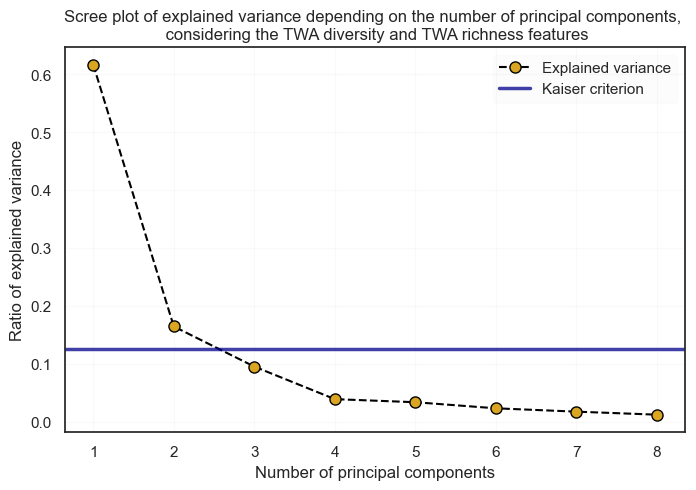

In [2233]:
# scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o',markersize=8, markerfacecolor='goldenrod', linestyle='--', color='black', label='Explained variance')

# Kaiser criterion line : eigenvalue=1
kaiser = 1 / len(explained_variance_ratio)
plt.axhline(y=kaiser, color='darkblue', linestyle='-',lw=2.5, label='Kaiser criterion ',alpha=0.75)

plt.grid(True, alpha=0.1)
plt.title('Scree plot of explained variance depending on the number of principal components, \n considering the TWA diversity and TWA richness features')
plt.xlabel('Number of principal components')
plt.ylabel('Ratio of explained variance')
plt.legend(facecolor='grey',framealpha=0.025)

# Save the figure
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

plt.show()

In [2234]:
# Standard scaler on the cols
scaled_data = StandardScaler().fit_transform(df[pca_cols])

# Apply PCA
pca = PCA(n_components=2) # 2 components based on the Kaiser criterion
pca_result = pca.fit_transform(scaled_data)

# Joins the results of the two principal PCs to the df
df['Div_PCA_1'] = pca_result[:, 0]
df['Div_PCA_2'] = pca_result[:, 1]


In [2235]:
df.columns

Index(['hiveID', 'year', 'date', 'operationID', 'is_alive', 'E', 'T',
       'hive_age', 'LS_rich_500', 'LS_rich_1000', 'LS_rich_2500',
       'LS_rich_5000', 'LS_SDI_500', 'LS_SDI_1000', 'LS_SDI_2500',
       'LS_SDI_5000', 'LS_EVI_apr', 'LS_EVI_jul', 'LS_EVI_oct', 'LS_elevation',
       'LS_elevation_std_dev', 'time_interval', 'TWA_rich_500',
       'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000', 'TWA_SDI_500',
       'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 'LS_EVI', 'TWA_EVI',
       'TWA_elevation', 'TWA_elevation_std_dev', 'maj_crop_500',
       'maj_crop_1000', 'maj_crop_2500', 'most_visited_crop_500',
       'most_visited_crop_1000', 'most_visited_crop_2500', 'nbr_visited_crops',
       'nbr_visited_crops_per_year', 'PCA1', 'PCA2'],
      dtype='object')

In [2246]:
# New list of rsf columns
rsf_cols = ['TWA_EVI','nbr_visited_crops_per_year','TWA_elevation','TWA_elevation_std_dev','Div_PCA_1','Div_PCA_2']

#### Training final RSF model

In [2276]:
# Best performing Rsf model
X = df[rsf_cols]
T = df['T'].astype(int)
E = df['E'].astype(int)

# Combine 'Years' and 'E' into a structured array for survival analysis
y = Surv.from_arrays(E, T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=E, random_state=1)

# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=200, random_state=1, max_depth=12, min_samples_leaf=4 
                        #   ,max_features='sqrt'
                           )

rsf.fit(X_train,y_train)
rsf.score(X_test,y_test)

0.847765257795352

### RSF results

#### Survival probability curves

In [2282]:
## creating a median grouped sample
## Creating a sample of the X split but adding the grouping column
median_sample = X.join(df[['most_visited_crop_500','T']]).groupby('most_visited_crop_500').median(numeric_only=True).reset_index()

median_sample.index = median_sample['most_visited_crop_500']

# Delete the column from its original position
del median_sample['most_visited_crop_500']

median_sample = median_sample.reindex(custom_order)

median_sample

,TWA_EVI,nbr_visited_crops_per_year,TWA_elevation,TWA_elevation_std_dev,Div_PCA_1,Div_PCA_2
most_visited_crop_500,,,,,,
Orchard,0.466153,3.0,102.250000,6.584514,0.757037,0.033051
Blueberry,0.532952,3.0,137.366197,2.317744,-2.051429,-0.209266
Soybean,0.486063,2.0,78.507937,2.733945,-0.252909,-0.136334
Pastures,0.531454,3.0,129.887240,3.427521,0.687209,0.153565
Deciduous,0.485577,2.0,91.029513,3.317706,-1.163004,-0.035203
Mixed forest,0.487648,3.0,128.847458,3.781780,-0.746222,0.544504
Coniferous,0.454761,4.0,143.470588,2.560345,-1.530977,0.910240
Wetland,0.493728,3.0,138.214660,2.045374,-1.318808,-0.445111
Urban,0.477866,3.0,59.793296,1.794570,0.013660,0.628321


In [ ]:
# Export median_sample
# median_sample.to_csv(r'path.csv',sep=';')

#Drop 'T' for next model training
median_sample = median_sample.drop(columns={'T'})

In [2324]:
# define a list of custom colors following the order above
custom_colors = [
    '#d40000',  # Orchard
    '#4682B4',  # Blueberry
    '#FF6347',  # Soybean 
    '#d1e903',  # Pastures 
    '#3dc502',  # Deciduous
    '#6f3900',  # Mixed Forest 
    '#006400',  # Coniferous 
    '#03ac90',  # Wetland turquoise
    '#7a23a9',  # Urban 
    '#6bd7fa',  # Water 
    '#f2f201',  # Canola
    '#db00de',  # Oilseed crops
    '#e69d00',  # Maize
    '#c1a47f',  # Cereal crops
    '#DB7093'   # Cranberry 
]

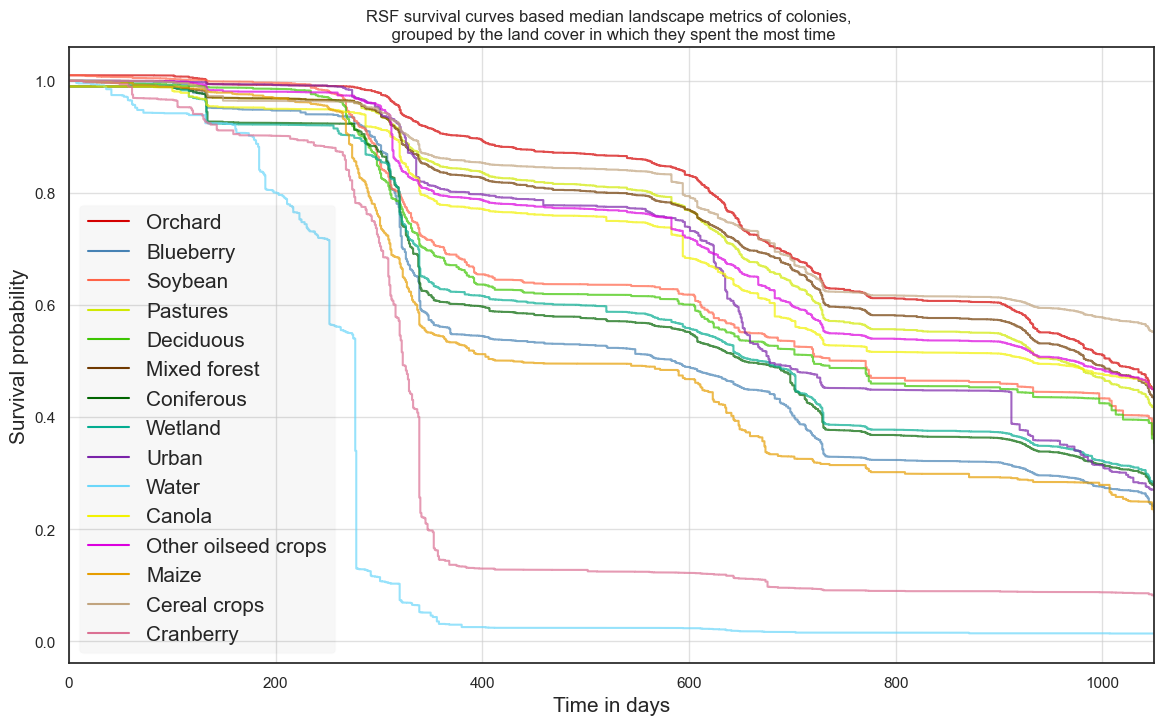

In [2326]:
# predict the survival functions following the sk-surv guidelines
surv = rsf.predict_survival_function(median_sample, return_array=True)

# Set the figure size
plt.figure(figsize=(14, 8))

# Plot survival functions for each crop group with the assigned colors
for i, (s, color) in enumerate(zip(surv, custom_colors)):
    
    # Improving readability by adding a small offset to overlapping functions
    if median_sample.iloc[i].name == 'Canola':
        s = s - 0.01
    if median_sample.iloc[i].name == 'Coniferous':
        s = s - 0.01 
    if median_sample.iloc[i].name == 'Orchard':
        s = s + 0.01
    if median_sample.iloc[i].name == 'Mixed forest':
        s = s - 0.01
    if median_sample.iloc[i].name == 'Soybean':
        s = s + 0.01
    
    # plot the curves
    plt.step(rsf.unique_times_, s, where="post", label=median_sample.iloc[i].name, color=color, alpha=0.7)

# figure params
plt.ylabel("Survival probability", fontsize=15)
plt.xlabel("Time in days", fontsize=15)
plt.title('RSF survival curves based median landscape metrics of colonies, \n grouped by the land cover in which they spent the most time')
plt.xlim(0, 1050)
legend = plt.legend(loc='best',frameon=True,facecolor='black',framealpha=0.03,prop={'size': 15})
plt.grid(True, alpha=0.6)
for handle in legend.get_lines():
    handle.set_alpha(1.0)  # Set the alpha for legend symbols to be fully opaque

# Export plot
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


Also possible but perhaps less interesting is to repeat this but considering the major crop in a 2500m buffer instead of local crop

In [2328]:
# Calculate the mean of 'days_alive' for each 'most_time_spent_crop'
mean_days_alive = df.groupby('most_visited_crop_2500')['T'].mean().sort_values()

mean_days_alive


most_visited_crop_2500
Cranberry       101.885714
Maize           217.892427
Water           261.939245
Wetland         262.100000
Cereal crops    304.950413
Pastures        362.442831
Mixed forest    384.538526
Urban           411.201183
Soybean         417.747055
Deciduous       421.152121
Coniferous      427.018265
Blueberry       462.515748
Orchard         710.382979
Name: T, dtype: float64

In [2329]:
# Defines a custom order of crops following the order by mean days alive
custom_order = mean_days_alive.index.to_list()
custom_order.reverse()
custom_order

['Orchard',
 'Blueberry',
 'Coniferous',
 'Deciduous',
 'Soybean',
 'Urban',
 'Mixed forest',
 'Pastures',
 'Cereal crops',
 'Wetland',
 'Water',
 'Maize',
 'Cranberry']

In [2330]:
## creating a median grouped sample
## Creating a sample of the X split but adding the grouping column
median_sample = X.join(df['most_visited_crop_2500']).groupby('most_visited_crop_2500').median(numeric_only=True).reset_index()

median_sample.index = median_sample['most_visited_crop_2500']

# Delete the column from its original position
del median_sample['most_visited_crop_2500']

median_sample = median_sample.reindex(custom_order)

median_sample

,TWA_EVI,nbr_visited_crops_per_year,TWA_elevation,TWA_elevation_std_dev,Div_PCA_1,Div_PCA_2
most_visited_crop_2500,,,,,,
Orchard,0.547520,3.0,82.978328,2.611306,0.650014,-0.117295
Blueberry,0.527344,3.0,133.256039,2.755216,-2.045137,-0.218380
Coniferous,0.521254,3.0,144.470320,1.957310,-2.202556,0.025576
Deciduous,0.493285,2.0,96.099563,3.899968,-1.019568,0.018660
Soybean,0.476353,2.0,69.127389,2.606632,-0.235135,-0.289887
Urban,0.481946,2.0,56.028427,2.417809,-0.127527,0.618265
Mixed forest,0.500651,3.0,129.022581,3.532527,0.101726,0.445945
Pastures,0.528976,3.0,147.494624,3.234893,0.846890,-0.241705
Cereal crops,0.520439,3.0,172.239130,2.185267,3.292641,-1.412568


In [2333]:
# 2500 m buffer color list
custom_colors = [
    '#d40000',  # Orchard 
    '#4682B4',  # Blueberry 
    '#006400',  # Coniferous 
    '#3dc502',  # Deciduous 
    '#FF6347',  # Soybean 
    '#7a23a9',  # Urban 
    '#6f3900',  # Mixed Forest
    '#d1e903',  # Pastures 
    '#c1a47f',  # Cereal crops
    '#03ac90',  # Wetland 
    '#e69d00',  # Maize 
    '#DB7093'   # Cranberry 
]

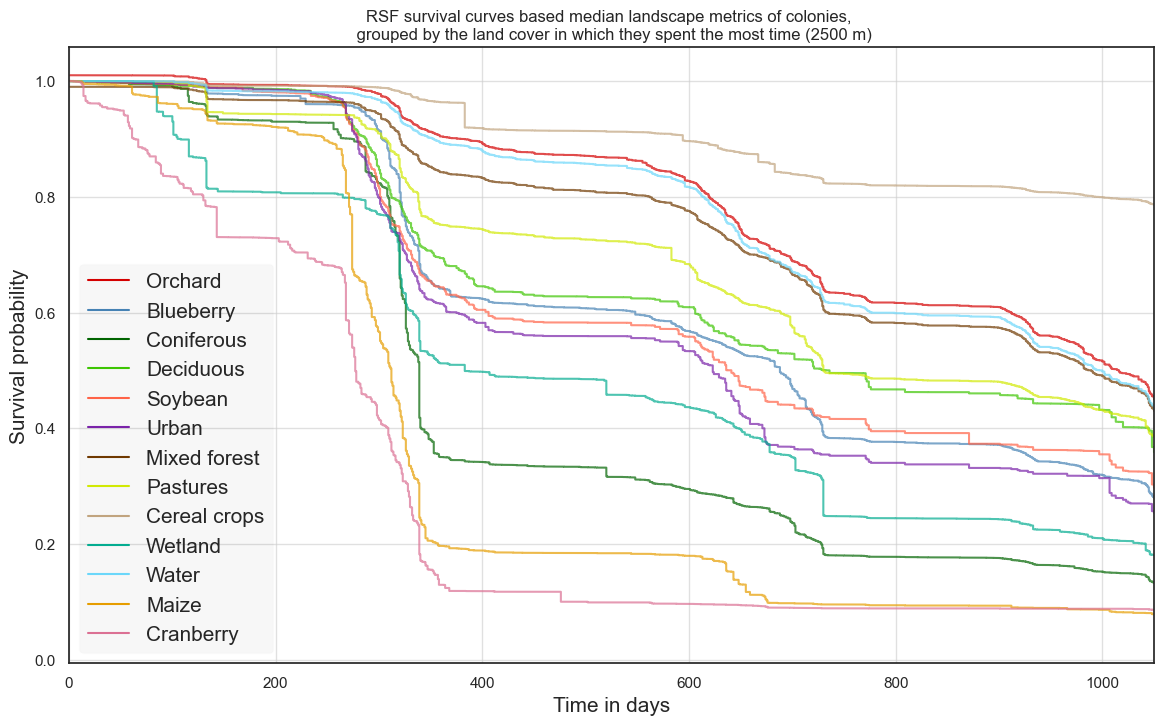

In [2337]:
# predict the survival functions following the sk-surv guidelines
surv = rsf.predict_survival_function(median_sample, return_array=True)

# Set the figure size
plt.figure(figsize=(14, 8))

# Plot survival functions for each crop group with the assigned colors
for i, (s, color) in enumerate(zip(surv, custom_colors)):
    
    # Improving readability by adding a small offset to overlapping functions
    # if median_sample.iloc[i].name == 'Canola':
    #     s = s - 0.01
    # if median_sample.iloc[i].name == 'Coniferous':
    #     s = s - 0.01 
    if median_sample.iloc[i].name == 'Orchard':
        s = s + 0.01
    if median_sample.iloc[i].name == 'Mixed forest':
        s = s - 0.01
    # if median_sample.iloc[i].name == 'Soybean':
    #     s = s + 0.01

    plt.step(rsf.unique_times_, s, where="post", label=median_sample.iloc[i].name, color=color, alpha=0.7)

# Customize the plot
plt.ylabel("Survival probability", fontsize=15)
plt.xlabel("Time in days", fontsize=15)
plt.title('RSF survival curves based median landscape metrics of colonies, \n grouped by the land cover in which they spent the most time (2500 m)')
plt.xlim(0, 1050)
legend = plt.legend(loc='best',frameon=True,facecolor='black',framealpha=0.03,prop={'size': 15})
plt.grid(True, alpha=0.6)
for handle in legend.get_lines():
    handle.set_alpha(1.0)  # Set the alpha for legend symbols to be fully opaque

# Save the figure (optional)
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
grouped_df = df.groupby('most_visited_crop_2500').agg(
    mean_days_alive=pd.NamedAgg(column='T', aggfunc='mean'),
    median_days_alive=pd.NamedAgg(column='T', aggfunc='median'),
    stddev_days_alive=pd.NamedAgg(column='T', aggfunc='std'),
    count=pd.NamedAgg(column='T', aggfunc='size')
).reset_index().round(0)

# Table for each crop group
grouped_df.columns = ['Group', 'Mean', 'Median', 'Std dev', 'Hive count']
grouped_df = grouped_df.sort_values('Mean')

# grouped_df.to_csv(r'path.csv',sep=';')
grouped_df

#### AUC

In [2356]:
# Concordance (C-index)
rsf.score(X_test, y_test)

0.844301668237576

In [2]:
#times = times #we use the same times as defined in the cox model.

# Compute predicted survival probabilities using the RSF model
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(times) for chf in rsf_chf_funcs])

# followign the sk-surv guidelines
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, times)

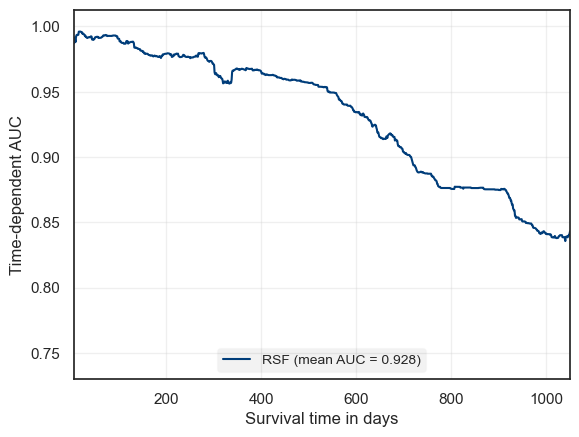

In [2365]:
# Choice of colors for the plot line
colors = ['#05009B', '#003D7A', '#2ca02c','#59007A','#D12900','#79004D']  

# Plot the AUC curve and label the mean AUC
plt.plot(times, rsf_auc, "-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})", color=colors[1]) #  choose the color by index

# Plot parameters
plt.xlabel("Survival time in days", fontsize=12)  
plt.ylabel("Time-dependent AUC", fontsize=12)
plt.xlim(5, 1050)
plt.legend(loc="lower center", fontsize=10,framealpha=0.05) 
plt.grid(alpha=0.3)

#save the fig
# plt.savefig(r'path.png',dpi=300,bbox_inches='tight')


plt.show()

We can then compare this predicted AUC of the RSF with the Cox PH model

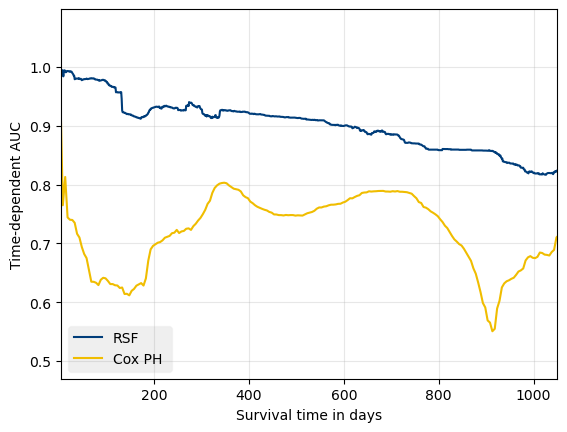

In [ ]:
# Choice of colors for the plot line
colors = ['#05009B', '#003D7A', '#2ca02c','#59007A','#D12900','#79004D','#f0bd00']  

# Plot the AUC curve and label the mean AUC
plt.plot(times, rsf_auc, "-", label=f"RSF", color=colors[1]) #  choose the color by index

plt.plot(times, cox_auc, "-", label=f"Cox PH ", color=colors[6]) #  choose the color by index

# plot parameters
plt.xlabel("Survival time in days", fontsize=10)  
plt.ylabel("Time-dependent AUC", fontsize=10)
plt.xlim(5, 1050)
plt.ylim(0.47,1.098)
plt.legend(loc="lower left", fontsize=10,framealpha=0.12,facecolor='grey') 
plt.grid(alpha=0.3)

#save the fig
plt.savefig(r'd:\JV\my_papers\diversity-evi-crops\RSF-Cox_AUC-plot.png',dpi=300,bbox_inches='tight')


plt.show()

#### Feature importance

Estimating feature importance of full RSF model

In [2343]:
# Estimating feature importance using 4 fold permutation (using scikit-learn permutation importance)
result = permutation_importance(rsf, X_test, y_test, n_repeats=4, random_state=1)

In [2350]:
var_imp = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

# round decimals
var_imp = var_imp.round(4)

var_imp

,importances_mean,importances_std
nbr_visited_crops_per_year,0.150074,0.005150
TWA_EVI,0.075393,0.000884
Div_PCA_1,0.026724,0.001092
TWA_elevation,0.026298,0.000871
TWA_elevation_std_dev,0.022843,0.001329
Div_PCA_2,0.012969,0.001724


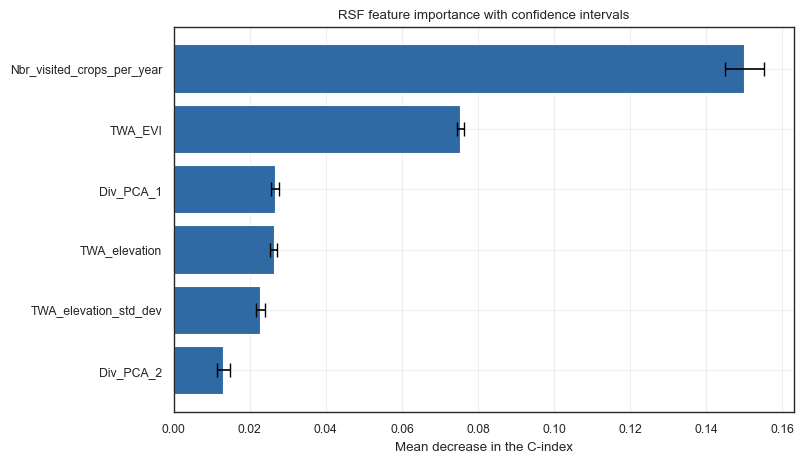

In [ ]:


# ploting vimp
plt.figure(figsize=(8, 5))

plt.barh(vimp['Feature'], vimp['Mean importance'], xerr=vimp['Std. dev. importance'], 
         capsize=5, color='#2f6aa4', ecolor='black', linestyle='-')


plt.xlabel('Mean decrease in the C-index')
plt.title('RSF feature importance with confidence intervals')
plt.gca().invert_yaxis() 
plt.grid(True, alpha=0.3)

# plt.savefig(r'path',dpi=300,bbox_inches='tight')

plt.show()

In [2358]:
# export var imp table
# var_imp.to_csv(r'path\var_imp.csv')

# Appendix 1 : Code used to retrieve EVI data

In [ ]:
break

In [ ]:
# function for evi

def get_evi(point,i_date,f_date):
  poi = ee.Geometry.Point(point.x, point.y)
  
  # select the modis product
  product = ee.ImageCollection('MODIS/061/MOD13A1')
  scale = 500 # resolution of product is 500 m

  evi = product.select('EVI').filterDate(i_date, f_date)

  mean_evi = evi.getRegion(poi, scale).getInfo()

  return mean_evi

dates have to be edited and the function repeated on ugdf

In [ ]:
# Initial date of interest (edit)
i_date = '2023-09-01'

# Final date of interest (exclusive).
f_date = '2023-10-15'

evi_list = []
c = 0

for i, row in ugdf.iterrows():
  #evi function
  data = get_evi(row.geometry, i_date, f_date)

  temp_df = pd.DataFrame(data[1:], columns=data[0])
  evi_list.append(temp_df['EVI'].mean())

  #counter
  c += 1
  if c % 10 == 0:  # Check if 'c' is a multiple of 10
      print(c)

  #delay
  # time.sleep(1)

# add evi values to gdf
ugdf['evi_sept'] = evi_list
ugdf['evi_sept'] = ugdf['evi_sept'] * 0.0001 #ratio from the MODIS user guide

In [ ]:
# exporting the csv of EO data
export_df = ugdf[['geometry','fpar_sept', 'evi_sept', 'fpar_jun','evi_jun','fpar_apr','evi_apr']]
# export_df.to_csv('path//eo-data_24.csv')